In [1]:
import pandas as pd
import scipy as sp
import numpy as np

from abtools.bayesian import LognormalABModel, WaldABModel
from abtools.plotting import qqplot, ppplot

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
data = pd.read_csv('data.csv').query('revenue > 0')

In [3]:
log_data = np.log(data.revenue)

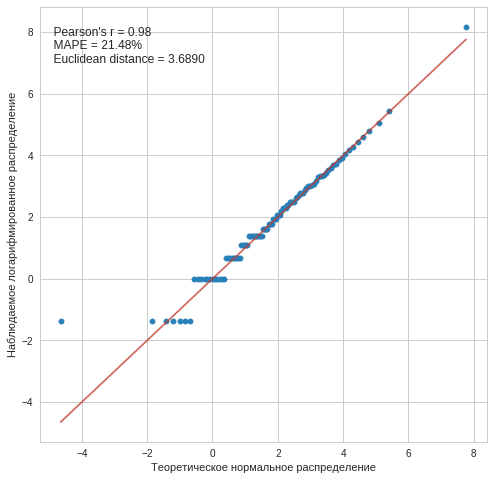

In [4]:
ax = qqplot(sp.stats.norm(log_data.mean(), log_data.std()).rvs(10000), log_data, num_points=100)[0]
ax.set_xlabel('Теоретическое нормальное распределение')
ax.set_ylabel('Наблюдаемое логарифмированное распределение')
ax.set_title('')
plt.savefig('qqplotlognormal.pdf')

In [5]:
a = data.query('abgroup == "control"')['revenue']
b = data.query('abgroup == "test"')['revenue']

print('ARPPU')
print('Mean: %.4f' % a.mean())
print('Mean: %.4f' % b.mean())
print('B больше A на %.4f = %d%%' % (b.mean()- a.mean(), 
                                    (b.mean() / a.mean()-1)*100))

ARPPU
Mean: 21.0090
Mean: 21.3889
B больше A на 0.3800 = 1%


In [6]:
model = LognormalABModel(a, b)
model.fit()#sample_ppc=True)

         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 113
         Gradient evaluations: 102


100%|██████████| 10000/10000 [00:14<00:00, 698.00it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cd3961588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0cd67bec88>], dtype=object)

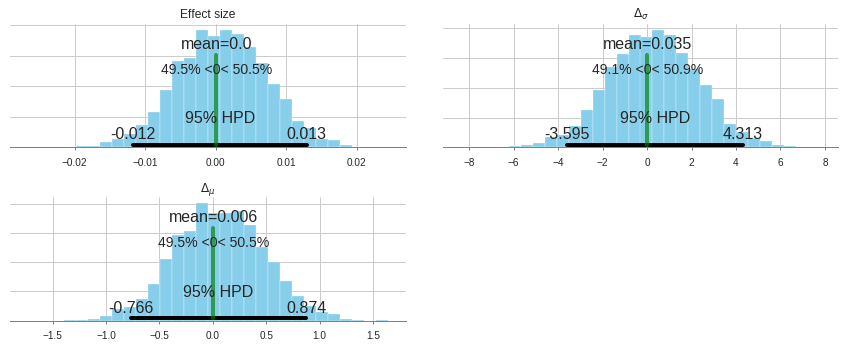

In [13]:
model.plot_deltas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cd6aa8048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0ce56dd6d8>], dtype=object)

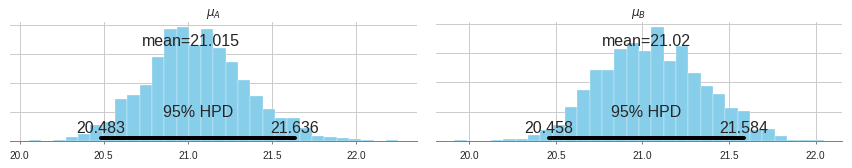

In [14]:
model.plot_params()

In [9]:
ax = qqplot(np.log(a), np.log(model.posterior['$A$']), num_points=100)[0]
ax.set_xlabel('Наблюдаемое логарифмированное распределение')
ax.set_ylabel('Апостериорное логарифмированное распределение')
ax.set_title('')
plt.savefig('qqplotlognormal.pdf')

AttributeError: 'LognormalABModel' object has no attribute 'posterior'

In [10]:
model = WaldABModel(a, b*4)
model.fit()#sample_ppc=True)

         Current function value: 405973.238673
         Iterations: 55
         Function evaluations: 139
         Gradient evaluations: 129


100%|██████████| 10000/10000 [00:18<00:00, 548.90it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a88955390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2a7e4f75f8>], dtype=object)

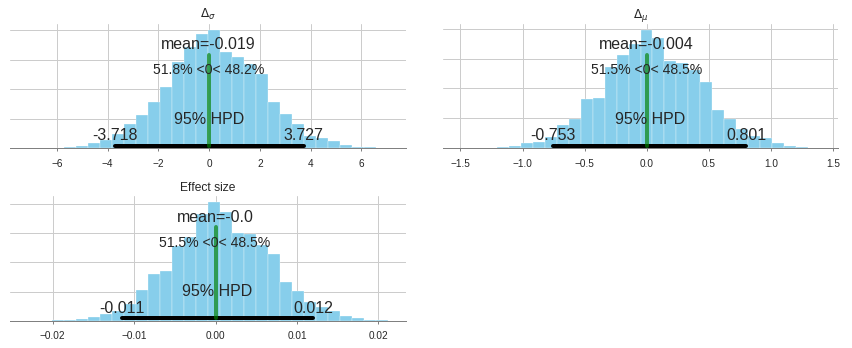

In [11]:
model.plot_deltas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5546763550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5546632828>], dtype=object)

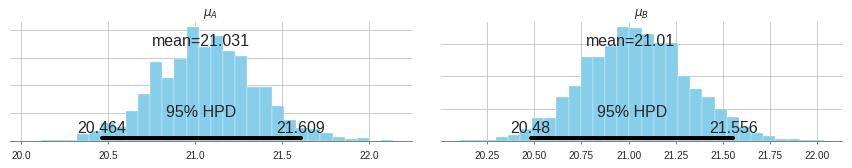

In [10]:
model.plot_params()

In [11]:
def CLT_model(a, b):
    model_a = sp.stats.norm.rvs(a.mean(), a.std() / np.sqrt(len(a)), size=10000)
    model_b = sp.stats.norm.rvs(b.mean(), b.std() / np.sqrt(len(b)), size=10000)
    diff = model_b - model_a
    return (diff > 0).mean()

In [8]:
results = []
for frac in range(1, 21):
    print('Start bootstraping with sample fraction =', frac/10)
    signs = {
            'lognormal_signs': [],
            'wald_signs': [],
            'ztest_signs': [],
            'perm_test_signs': [],
            'CLT_signs': [],
            'a_se': [],
            'b_se': [],
            'a_mean': [],
            'b_mean': []
        }
    
    for i in range(25):
        print('\tbootstrap_iter =', i)
        a_tmp = a.sample(frac=frac/20)
        b_tmp = b.sample(frac=frac/20)
        model = LognormalABModel(a_tmp, b_tmp)
        model.fit()
        signs['ztest_signs'].append(ZTest(a_tmp, b_tmp).significance)
        signs['a_se'].append(sp.stats.sem(a_tmp))
        signs['b_se'].append(sp.stats.sem(b_tmp))
        signs['a_mean'].append(a_tmp.mean())
        signs['b_mean'].append(b_tmp.mean())
        signs['perm_test_signs'].append((1 - PermutationTest(a_tmp, b_tmp).p_value))
        signs['CLT_signs'].append(CLT_model(a_tmp, b_tmp))
        signs['lognormal_signs'].append(np.mean(model.trace['$\\Delta_{\\mu}$'] > 0))
    
    result = {
            'a_sample_size': len(a_tmp),
            'b_sample_size': len(b_tmp),
            'a_se': np.mean(signs['a_se']),
            'b_se': np.mean(signs['b_se']),
            'a_mean': np.mean(signs['a_mean']),
            'b_mean': np.mean(signs['b_mean']),
            'fraction': frac/20,
            'lognormal_sign': np.mean(signs['lognormal_signs']),
            'lognormal_var': np.var(signs['lognormal_signs']),
            'ztest_sign': np.mean(signs['ztest_signs']),
            'ztest_var': np.var(signs['ztest_signs']),
            'perm_test_sign': np.mean(signs['perm_test_signs']),
            'perm_test_var': np.var(signs['perm_test_signs']),
            'CLT_sign': np.mean(signs['CLT_signs']),
            'CLT_var': np.var(signs['CLT_signs']),
        }
    print(result)
    results.append(result)
#a.sample(frac=frac)

Start bootstraping with sample fraction = 0.1
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 19985.339149
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:00<00:00, 10092.55it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 20072.270163
         Iterations: 8
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:00<00:00, 10011.21it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 19901.807733
         Iterations: 9
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:00<00:00, 10053.81it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 19891.070591
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:01<00:00, 9569.90it/s]


	bootstrap_iter = 4
         Current function value: 19748.679451
         Iterations: 13
         Function evaluations: 55
         Gradient evaluations: 44

100%|██████████| 10000/10000 [00:01<00:00, 9860.82it/s]



	bootstrap_iter = 5
         Current function value: 19964.640252
         Iterations: 12
         Function evaluations: 78
         Gradient evaluations: 67


100%|██████████| 10000/10000 [00:00<00:00, 10369.95it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 19527.937930
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:01<00:00, 9502.84it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 19950.966972
         Iterations: 15
         Function evaluations: 89
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:00<00:00, 10168.57it/s]


	bootstrap_iter = 8
         Current function value: 19825.205714
         Iterations: 13
         Function evaluations: 155
         Gradient evaluations: 142


100%|██████████| 10000/10000 [00:00<00:00, 10208.40it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 19747.076319
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:00<00:00, 10116.53it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 19860.405818
         Iterations: 9
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:01<00:00, 9599.93it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 19567.506129
         Iterations: 8
         Function evaluations: 13
         Gradient evaluations: 13


100%|██████████| 10000/10000 [00:00<00:00, 10410.43it/s]


	bootstrap_iter = 12
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:01<00:00, 9806.02it/s]


         Current function value: 19797.358447
         Iterations: 9
         Function evaluations: 18
         Gradient evaluations: 18
	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 19861.190213
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:00<00:00, 10043.96it/s]


	bootstrap_iter = 14
         Current function value: 19930.673523
         Iterations: 9
         Function evaluations: 126
         Gradient evaluations: 114


100%|██████████| 10000/10000 [00:01<00:00, 9969.32it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 19753.915179
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:00<00:00, 10090.59it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 19892.441232
         Iterations: 8
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:01<00:00, 9828.72it/s]


	bootstrap_iter = 17
Optimization terminated successfully.
         Current function value: 19883.081664
         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:00<00:00, 10026.27it/s]


	bootstrap_iter = 18
         Current function value: 19826.430181
         Iterations: 12
         Function evaluations: 125
         Gradient evaluations: 114


100%|██████████| 10000/10000 [00:00<00:00, 10248.73it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 19721.229858
         Iterations: 8
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:00<00:00, 10241.33it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 19781.420814


100%|██████████| 10000/10000 [00:00<00:00, 10394.75it/s]


         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 19920.408292
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:00<00:00, 10631.10it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 19805.959598
         Iterations: 15
         Function evaluations: 138
         Gradient evaluations: 133


100%|██████████| 10000/10000 [00:00<00:00, 10678.28it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 19895.997308
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:00<00:00, 10656.28it/s]


	bootstrap_iter = 24
         Current function value: 19765.912365
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:00<00:00, 10771.51it/s]


{'b_se': 1.1637550249027244, 'a_sample_size': 2676, 'perm_test_var': 0.082094319999999998, 'a_se': 1.0722618819556424, 'CLT_var': 0.10670891801599998, 'a_mean': 21.090089387144996, 'b_sample_size': 2650, 'fraction': 0.05, 'lognormal_sign': 0.65940266666666658, 'b_mean': 21.548943849056606, 'ztest_sign': 0.49318846315156784, 'CLT_sign': 0.57517200000000002, 'ztest_var': 0.070243330537681684, 'lognormal_var': 0.10010971323733334, 'perm_test_sign': 0.60519999999999996}
Start bootstraping with sample fraction = 0.2
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 39236.099095
         Iterations: 10
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:01<00:00, 6081.68it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 39673.521672
         Iterations: 9
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:01<00:00, 6076.65it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 39861.544202
         Iterations: 8
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:01<00:00, 6081.63it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 39531.886229
         Iterations: 9
         Function evaluations: 18

100%|██████████| 10000/10000 [00:01<00:00, 6072.48it/s]



         Gradient evaluations: 18
	bootstrap_iter = 4


100%|██████████| 10000/10000 [00:01<00:00, 6075.73it/s]


         Current function value: 39528.872166
         Iterations: 12
         Function evaluations: 86
         Gradient evaluations: 75
	bootstrap_iter = 5
         Current function value: 39531.018510
         Iterations: 8
         Function evaluations: 79
         Gradient evaluations: 68


100%|██████████| 10000/10000 [00:01<00:00, 6080.71it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 39583.612039
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:01<00:00, 6084.97it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 39616.358066
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:01<00:00, 6116.00it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 39461.349370
         Iterations: 10
         Function evaluations: 63
         Gradient evaluations: 60


100%|██████████| 10000/10000 [00:01<00:00, 6058.21it/s]


	bootstrap_iter = 9
         Current function value: 39644.643126
         Iterations: 9
         Function evaluations: 75
         Gradient evaluations: 64


100%|██████████| 10000/10000 [00:01<00:00, 6094.67it/s]


	bootstrap_iter = 10
         Current function value: 39802.624385
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:01<00:00, 6060.36it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 39682.042567
         Iterations: 8
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:01<00:00, 6094.30it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 39645.380002
         Iterations: 9
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:01<00:00, 6086.47it/s]


	bootstrap_iter = 13
         Current function value: 39611.803521
         Iterations: 9
         Function evaluations: 76
         Gradient evaluations: 65


100%|██████████| 10000/10000 [00:01<00:00, 6045.69it/s]


	bootstrap_iter = 14
         Current function value: 39531.037090
         Iterations: 8
         Function evaluations: 153
         Gradient evaluations: 142


100%|██████████| 10000/10000 [00:01<00:00, 6061.24it/s]


	bootstrap_iter = 15
         Current function value: 39545.475729
         Iterations: 13
         Function evaluations: 173
         Gradient evaluations: 160


100%|██████████| 10000/10000 [00:01<00:00, 6045.33it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 39307.924690
         Iterations: 8
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:01<00:00, 6073.18it/s]


	bootstrap_iter = 17
Optimization terminated successfully.
         Current function value: 39696.635521
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:01<00:00, 6078.34it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 39929.889614
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:01<00:00, 6039.31it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 39390.660429
         Iterations: 10
         Function evaluations: 59
         Gradient evaluations: 57


100%|██████████| 10000/10000 [00:01<00:00, 6093.31it/s]


	bootstrap_iter = 20
         Current function value: 39713.178551
         Iterations: 9
         Function evaluations: 61
         Gradient evaluations: 51


100%|██████████| 10000/10000 [00:01<00:00, 6000.47it/s]


	bootstrap_iter = 21
         Current function value: 39803.378183
         Iterations: 10
         Function evaluations: 164
         Gradient evaluations: 151


100%|██████████| 10000/10000 [00:01<00:00, 6119.91it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 39452.718846
         Iterations: 9
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:01<00:00, 6050.37it/s]


	bootstrap_iter = 23


100%|██████████| 10000/10000 [00:01<00:00, 6070.16it/s]


         Current function value: 39387.090855
         Iterations: 12
         Function evaluations: 102
         Gradient evaluations: 92
	bootstrap_iter = 24
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:01<00:00, 6084.15it/s]


         Current function value: 39586.229950
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 17
{'b_se': 0.81587497909623341, 'a_sample_size': 5351, 'perm_test_var': 0.058346204415999997, 'a_se': 0.77830706508420844, 'CLT_var': 0.065130025504000003, 'a_mean': 21.17694666417492, 'b_sample_size': 5299, 'fraction': 0.1, 'lognormal_sign': 0.60660266666666673, 'b_mean': 21.173077335346292, 'ztest_sign': 0.34327194236516689, 'CLT_sign': 0.50223600000000002, 'ztest_var': 0.042809871556260065, 'lognormal_var': 0.075870451370666669, 'perm_test_sign': 0.44792799999999999}
Start bootstraping with sample fraction = 0.3
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 59534.530133
         Iterations: 9
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:02<00:00, 4374.05it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 59473.395220
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:02<00:00, 4359.20it/s]


	bootstrap_iter = 2
         Current function value: 59856.132891
         Iterations: 8
         Function evaluations: 92
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:02<00:00, 4334.46it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 59200.104995
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:02<00:00, 4421.71it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 59360.890191

100%|██████████| 10000/10000 [00:02<00:00, 4479.70it/s]



         Iterations: 11
         Function evaluations: 20
         Gradient evaluations: 20
	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 59397.643383
         Iterations: 11
         Function evaluations: 23
         Gradient evaluations: 23


100%|██████████| 10000/10000 [00:02<00:00, 4423.13it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 59390.967950
         Iterations: 8
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:02<00:00, 4378.21it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 58775.776853
         Iterations: 8
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:02<00:00, 4584.37it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 59593.940720
         Iterations: 8
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:02<00:00, 4473.07it/s]


	bootstrap_iter = 9
         Current function value: 59495.193971
         Iterations: 16
         Function evaluations: 226
         Gradient evaluations: 210

100%|██████████| 10000/10000 [00:02<00:00, 4572.17it/s]



	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 59425.772466
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:02<00:00, 4406.49it/s]


	bootstrap_iter = 11
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:02<00:00, 4498.80it/s]


         Current function value: 59699.257861
         Iterations: 8
         Function evaluations: 15
         Gradient evaluations: 15
	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 59284.774683
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:02<00:00, 4413.68it/s]


	bootstrap_iter = 13
         Current function value: 59330.068307
         Iterations: 8
         Function evaluations: 86
         Gradient evaluations: 75


100%|██████████| 10000/10000 [00:02<00:00, 4367.85it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 59191.346930
         Iterations: 16
         Function evaluations: 27
         Gradient evaluations: 27


100%|██████████| 10000/10000 [00:02<00:00, 4429.09it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 59400.380683
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:02<00:00, 4454.33it/s]


	bootstrap_iter = 16
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:02<00:00, 4439.76it/s]


         Current function value: 59288.303423
         Iterations: 8
         Function evaluations: 16
         Gradient evaluations: 16
	bootstrap_iter = 17
         Current function value: 59254.639893
         Iterations: 7
         Function evaluations: 92
         Gradient evaluations: 80


100%|██████████| 10000/10000 [00:02<00:00, 4423.87it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 59194.342916
         Iterations: 9
         Function evaluations: 21
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:02<00:00, 4376.36it/s]


	bootstrap_iter = 19
         Current function value: 59326.358490
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 70


100%|██████████| 10000/10000 [00:02<00:00, 4484.28it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 59160.325196
         Iterations: 12
         Function evaluations: 27
         Gradient evaluations: 27


100%|██████████| 10000/10000 [00:02<00:00, 4498.14it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 59647.996606
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:02<00:00, 4377.63it/s]


	bootstrap_iter = 22
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:02<00:00, 4447.77it/s]


         Current function value: 59634.566044
         Iterations: 10
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 59631.330933
         Iterations: 14
         Function evaluations: 90
         Gradient evaluations: 89


100%|██████████| 10000/10000 [00:02<00:00, 4401.22it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 59873.042106
         Iterations: 15
         Function evaluations: 60
         Gradient evaluations: 59


100%|██████████| 10000/10000 [00:02<00:00, 4365.61it/s]


{'b_se': 0.68366105737115801, 'a_sample_size': 8026, 'perm_test_var': 0.065072426335999994, 'a_se': 0.64003095530912291, 'CLT_var': 0.059276947616000004, 'a_mean': 21.123865287814606, 'b_sample_size': 7948, 'fraction': 0.15, 'lognormal_sign': 0.6737333333333333, 'b_mean': 21.408675239053849, 'ztest_sign': 0.34201115328759757, 'CLT_sign': 0.57527200000000012, 'ztest_var': 0.050195563487637748, 'lognormal_var': 0.055418185955555553, 'perm_test_sign': 0.44130800000000003}
Start bootstraping with sample fraction = 0.4
	bootstrap_iter = 0
         Current function value: 79360.140914
         Iterations: 8
         Function evaluations: 111
         Gradient evaluations: 100


100%|██████████| 10000/10000 [00:03<00:00, 3109.97it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 79110.912486
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20

100%|██████████| 10000/10000 [00:03<00:00, 3152.76it/s]



	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 79237.615327
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:03<00:00, 3141.17it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 79579.992189

100%|██████████| 10000/10000 [00:03<00:00, 3156.32it/s]



         Iterations: 9
         Function evaluations: 56
         Gradient evaluations: 55
	bootstrap_iter = 4
         Current function value: 79413.226877
         Iterations: 7
         Function evaluations: 94
         Gradient evaluations: 83


100%|██████████| 10000/10000 [00:03<00:00, 3145.01it/s]


	bootstrap_iter = 5
         Current function value: 79421.250331
         Iterations: 9
         Function evaluations: 127
         Gradient evaluations: 114


100%|██████████| 10000/10000 [00:03<00:00, 3153.13it/s]


	bootstrap_iter = 6
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:03<00:00, 3105.90it/s]


         Current function value: 79120.548723
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 59
	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 79272.716636
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:03<00:00, 3108.86it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 79153.891759
         Iterations: 10
         Function evaluations: 29


100%|██████████| 10000/10000 [00:03<00:00, 3144.85it/s]


         Gradient evaluations: 29
	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 79278.099266
         Iterations: 10
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:03<00:00, 3134.79it/s]


	bootstrap_iter = 10
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:03<00:00, 3117.82it/s]


         Current function value: 79272.778733
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18
	bootstrap_iter = 11
         Current function value: 79293.612055
         Iterations: 13


100%|██████████| 10000/10000 [00:03<00:00, 3124.41it/s]


         Function evaluations: 81
         Gradient evaluations: 70
	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 78997.191728
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:03<00:00, 3099.81it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 78874.191180
         Iterations: 9
         Function evaluations: 17


100%|██████████| 10000/10000 [00:03<00:00, 3170.44it/s]


         Gradient evaluations: 17
	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 78943.776963
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:03<00:00, 3135.98it/s]


	bootstrap_iter = 15
         Current function value: 79155.251561
         Iterations: 7
         Function evaluations: 81
         Gradient evaluations: 71


100%|██████████| 10000/10000 [00:03<00:00, 3121.49it/s]


	bootstrap_iter = 16
         Current function value: 79906.797885
         Iterations: 12
         Function evaluations: 82
         Gradient evaluations: 70


100%|██████████| 10000/10000 [00:03<00:00, 3124.95it/s]


	bootstrap_iter = 17
         Current function value: 79307.157445
         Iterations: 10
         Function evaluations: 183

100%|██████████| 10000/10000 [00:03<00:00, 3120.13it/s]



         Gradient evaluations: 169
	bootstrap_iter = 18
         Current function value: 79351.952705

100%|██████████| 10000/10000 [00:03<00:00, 3285.46it/s]



         Iterations: 13
         Function evaluations: 113
         Gradient evaluations: 102
	bootstrap_iter = 19
         Current function value: 79085.752839
         Iterations: 7
         Function evaluations: 66
         Gradient evaluations: 55


100%|██████████| 10000/10000 [00:03<00:00, 3163.96it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 79120.839224
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:03<00:00, 3216.38it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 79199.179302
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:03<00:00, 3133.92it/s]


	bootstrap_iter = 22
         Current function value: 78871.052752
         Iterations: 12
         Function evaluations: 99
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:03<00:00, 3176.11it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 79273.630006
         Iterations: 8
         Function evaluations: 14


100%|██████████| 10000/10000 [00:03<00:00, 3197.66it/s]


         Gradient evaluations: 14
	bootstrap_iter = 24
         Current function value: 79294.059675
         Iterations: 8
         Function evaluations: 174
         Gradient evaluations: 162


100%|██████████| 10000/10000 [00:03<00:00, 3108.76it/s]


{'b_se': 0.58374109775514382, 'a_sample_size': 10702, 'perm_test_var': 0.085849980800000003, 'a_se': 0.55250953569192374, 'CLT_var': 0.04321917305600001, 'a_mean': 21.086205980190616, 'b_sample_size': 10598, 'fraction': 0.2, 'lognormal_sign': 0.7827466666666667, 'b_mean': 21.431804227212684, 'ztest_sign': 0.31820021033307488, 'CLT_sign': 0.640988, 'ztest_var': 0.060772170427594786, 'lognormal_var': 0.038461860977777776, 'perm_test_sign': 0.40992000000000006}
Start bootstraping with sample fraction = 0.5
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 99185.773120
         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:03<00:00, 2645.57it/s]


	bootstrap_iter = 1
         Current function value: 99184.405775
         Iterations: 8
         Function evaluations: 82
         Gradient evaluations: 71


100%|██████████| 10000/10000 [00:03<00:00, 2681.06it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 99046.636895
         Iterations: 9
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:03<00:00, 2700.65it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 98803.525140
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:03<00:00, 2633.49it/s]


	bootstrap_iter = 4
         Current function value: 98701.030049
         Iterations: 10
         Function evaluations: 86
         Gradient evaluations: 76


100%|██████████| 10000/10000 [00:03<00:00, 2634.34it/s]


	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 98836.542102
         Iterations: 14
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:03<00:00, 2705.27it/s]


	bootstrap_iter = 6
         Current function value: 99006.953506
         Iterations: 13


100%|██████████| 10000/10000 [00:03<00:00, 2609.82it/s]


         Function evaluations: 141
         Gradient evaluations: 129
	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 99200.767112
         Iterations: 8
         Function evaluations: 18


100%|██████████| 10000/10000 [00:03<00:00, 2585.32it/s]


         Gradient evaluations: 18
	bootstrap_iter = 8
         Current function value: 99091.439208
         Iterations: 13
         Function evaluations: 109
         Gradient evaluations: 98


100%|██████████| 10000/10000 [00:03<00:00, 2590.27it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 99132.666702
         Iterations: 9
         Function evaluations: 74
         Gradient evaluations: 71


100%|██████████| 10000/10000 [00:03<00:00, 2650.49it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 99169.965272
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:03<00:00, 2582.80it/s]


	bootstrap_iter = 11
         Current function value: 99244.749997
         Iterations: 8
         Function evaluations: 119
         Gradient evaluations: 106


100%|██████████| 10000/10000 [00:03<00:00, 2606.39it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 99069.791496
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:03<00:00, 2607.58it/s]


	bootstrap_iter = 13


100%|██████████| 10000/10000 [00:03<00:00, 2614.19it/s]


         Current function value: 99306.735490
         Iterations: 12
         Function evaluations: 97
         Gradient evaluations: 85
	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 99402.441336
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:03<00:00, 2615.99it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 98917.528112
         Iterations: 9
         Function evaluations: 18

100%|██████████| 10000/10000 [00:03<00:00, 2630.87it/s]



         Gradient evaluations: 18
	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 99286.177628
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:03<00:00, 2599.07it/s]


	bootstrap_iter = 17
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:03<00:00, 2615.55it/s]


         Current function value: 99209.160796
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 20
	bootstrap_iter = 18
         Current function value: 99376.625229
         Iterations: 8
         Function evaluations: 88
         Gradient evaluations: 78


100%|██████████| 10000/10000 [00:03<00:00, 2708.23it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 98866.576917
         Iterations: 9
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:03<00:00, 2709.98it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 98923.096317
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:03<00:00, 2602.30it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 99381.520466
         Iterations: 8
         Function evaluations: 16


100%|██████████| 10000/10000 [00:03<00:00, 2574.17it/s]


         Gradient evaluations: 16
	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 99315.629031
         Iterations: 9
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:03<00:00, 2619.31it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 98658.641724
         Iterations: 14
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:03<00:00, 2572.89it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 98919.194974
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:03<00:00, 2613.68it/s]


{'b_se': 0.52184583517092253, 'a_sample_size': 13378, 'perm_test_var': 0.061795145056000006, 'a_se': 0.48127966915882558, 'CLT_var': 0.090076526975999993, 'a_mean': 21.082646045746753, 'b_sample_size': 13248, 'fraction': 0.25, 'lognormal_sign': 0.74667200000000011, 'b_mean': 21.357337016908215, 'ztest_sign': 0.46687914151753263, 'CLT_sign': 0.61406800000000006, 'ztest_var': 0.048897656282108237, 'lognormal_var': 0.046552477127111108, 'perm_test_sign': 0.59288799999999997}
Start bootstraping with sample fraction = 0.6
	bootstrap_iter = 0
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:04<00:00, 2307.56it/s]


         Current function value: 118971.515449
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18
	bootstrap_iter = 1
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:04<00:00, 2317.41it/s]


         Current function value: 118977.263506
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20
	bootstrap_iter = 2
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:04<00:00, 2346.51it/s]


         Current function value: 118763.705118
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 3
         Current function value: 118857.332732
         Iterations: 9
         Function evaluations: 174
         Gradient evaluations: 161


100%|██████████| 10000/10000 [00:04<00:00, 2323.34it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 118667.942894
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:04<00:00, 2333.06it/s]


	bootstrap_iter = 5
         Current function value: 118849.997127
         Iterations: 9
         Function evaluations: 71
         Gradient evaluations: 58


100%|██████████| 10000/10000 [00:04<00:00, 2303.76it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 119133.211593
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:04<00:00, 2346.25it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 118857.552521
         Iterations: 10
         Function evaluations: 21
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:04<00:00, 2381.15it/s]


	bootstrap_iter = 8
         Current function value: 118934.223643
         Iterations: 9
         Function evaluations: 192
         Gradient evaluations: 178


100%|██████████| 10000/10000 [00:04<00:00, 2373.38it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 118999.901060
         Iterations: 9
         Function evaluations: 22
         Gradient evaluations: 22


100%|██████████| 10000/10000 [00:04<00:00, 2321.21it/s]


	bootstrap_iter = 10
         Current function value: 118855.482920
         Iterations: 8
         Function evaluations: 98
         Gradient evaluations: 88


100%|██████████| 10000/10000 [00:04<00:00, 2256.46it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 118519.122975
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:04<00:00, 2298.96it/s]


	bootstrap_iter = 12
         Current function value: 118445.682672
         Iterations: 8
         Function evaluations: 74
         Gradient evaluations: 63


100%|██████████| 10000/10000 [00:04<00:00, 2288.59it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 118803.517212
         Iterations: 9
         Function evaluations: 19

100%|██████████| 10000/10000 [00:04<00:00, 2324.44it/s]



         Gradient evaluations: 19
	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 118964.489307
         Iterations: 9
         Function evaluations: 54
         Gradient evaluations: 53


100%|██████████| 10000/10000 [00:04<00:00, 2286.27it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 118930.757727
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:04<00:00, 2283.71it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 118802.199419
         Iterations: 9
         Function evaluations: 21
         Gradient evaluations: 21

100%|██████████| 10000/10000 [00:04<00:00, 2272.19it/s]



	bootstrap_iter = 17
Optimization terminated successfully.
         Current function value: 118770.440184
         Iterations: 10
         Function evaluations: 74
         Gradient evaluations: 72


100%|██████████| 10000/10000 [00:04<00:00, 2322.00it/s]


	bootstrap_iter = 18
         Current function value: 118740.701524
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 64


100%|██████████| 10000/10000 [00:04<00:00, 2341.82it/s]


	bootstrap_iter = 19
         Current function value: 119055.394594
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 89


100%|██████████| 10000/10000 [00:04<00:00, 2343.38it/s]


	bootstrap_iter = 20
         Current function value: 118767.665247
         Iterations: 8
         Function evaluations: 143
         Gradient evaluations: 130


100%|██████████| 10000/10000 [00:04<00:00, 2324.52it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 118945.843712
         Iterations: 10
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:04<00:00, 2306.51it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 118956.313822
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:04<00:00, 2355.11it/s]


	bootstrap_iter = 23
         Current function value: 118566.983086
         Iterations: 7
         Function evaluations: 105
         Gradient evaluations: 93


100%|██████████| 10000/10000 [00:04<00:00, 2306.79it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 119119.913402
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:04<00:00, 2311.80it/s]


{'b_se': 0.46924634765713047, 'a_sample_size': 16053, 'perm_test_var': 0.076237552575999998, 'a_se': 0.448327937732034, 'CLT_var': 0.042736117343999999, 'a_mean': 21.091389123528316, 'b_sample_size': 15897, 'fraction': 0.3, 'lognormal_sign': 0.79937600000000009, 'b_mean': 21.414360772472797, 'ztest_sign': 0.33793276461086286, 'CLT_sign': 0.65881599999999996, 'ztest_var': 0.054390608227937447, 'lognormal_var': 0.031851512490666672, 'perm_test_sign': 0.43876800000000005}
Start bootstraping with sample fraction = 0.7
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 138173.804699
         Iterations: 10
         Function evaluations: 61
         Gradient evaluations: 60


100%|██████████| 10000/10000 [00:05<00:00, 1938.41it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 138606.049052
         Iterations: 10
         Function evaluations: 23
         Gradient evaluations: 23


100%|██████████| 10000/10000 [00:05<00:00, 1932.09it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 138668.059734
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:05<00:00, 1969.20it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 138733.781774
         Iterations: 10
         Function evaluations: 21
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:05<00:00, 1966.72it/s]


	bootstrap_iter = 4
         Current function value: 139051.367321

100%|██████████| 10000/10000 [00:05<00:00, 1934.05it/s]



         Iterations: 10
         Function evaluations: 116
         Gradient evaluations: 103
	bootstrap_iter = 5
         Current function value: 138453.287006

100%|██████████| 10000/10000 [00:05<00:00, 1946.91it/s]



         Iterations: 10
         Function evaluations: 76
         Gradient evaluations: 65
	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 138814.713463
         Iterations: 8

100%|██████████| 10000/10000 [00:05<00:00, 1916.44it/s]



         Function evaluations: 18
         Gradient evaluations: 18
	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 138555.925824
         Iterations: 9
         Function evaluations: 20

100%|██████████| 10000/10000 [00:05<00:00, 1985.86it/s]



         Gradient evaluations: 20
	bootstrap_iter = 8
         Current function value: 138956.065570
         Iterations: 9
         Function evaluations: 96
         Gradient evaluations: 84


100%|██████████| 10000/10000 [00:05<00:00, 1913.63it/s]


	bootstrap_iter = 9
         Current function value: 138397.230797
         Iterations: 10
         Function evaluations: 203

100%|██████████| 10000/10000 [00:05<00:00, 1919.99it/s]



         Gradient evaluations: 188
	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 137748.559640
         Iterations: 9
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:05<00:00, 1925.73it/s]


	bootstrap_iter = 11
         Current function value: 138835.679996
         Iterations: 10
         Function evaluations: 187
         Gradient evaluations: 174


100%|██████████| 10000/10000 [00:05<00:00, 1921.91it/s]


	bootstrap_iter = 12
         Current function value: 138425.843655
         Iterations: 10
         Function evaluations: 102
         Gradient evaluations: 90


100%|██████████| 10000/10000 [00:05<00:00, 1787.48it/s]


	bootstrap_iter = 13
         Current function value: 138429.733128
         Iterations: 8
         Function evaluations: 80
         Gradient evaluations: 69


100%|██████████| 10000/10000 [00:05<00:00, 1962.64it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 139029.588165
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:05<00:00, 1985.87it/s]


	bootstrap_iter = 15
         Current function value: 138703.679756
         Iterations: 10
         Function evaluations: 210
         Gradient evaluations: 196


100%|██████████| 10000/10000 [00:05<00:00, 1970.78it/s]


	bootstrap_iter = 16
         Current function value: 138613.257223
         Iterations: 8
         Function evaluations: 74
         Gradient evaluations: 63


100%|██████████| 10000/10000 [00:05<00:00, 1970.27it/s]


	bootstrap_iter = 17
Optimization terminated successfully.
         Current function value: 138671.233744
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:05<00:00, 1979.65it/s]


	bootstrap_iter = 18
         Current function value: 138723.174073
         Iterations: 10

100%|██████████| 10000/10000 [00:05<00:00, 1917.42it/s]



         Function evaluations: 94
         Gradient evaluations: 83
	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 138656.067428
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:05<00:00, 1930.34it/s]


	bootstrap_iter = 20
         Current function value: 138402.637429
         Iterations: 9
         Function evaluations: 138
         Gradient evaluations: 125


100%|██████████| 10000/10000 [00:05<00:00, 1921.75it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 138850.339243
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:05<00:00, 1912.73it/s]


	bootstrap_iter = 22
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:05<00:00, 1911.31it/s]


         Current function value: 138606.258108
         Iterations: 12
         Function evaluations: 199
         Gradient evaluations: 195
	bootstrap_iter = 23
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:05<00:00, 1712.56it/s]


         Current function value: 138462.616840
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18
	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 138833.374489
         Iterations: 9
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:05<00:00, 1927.99it/s]


{'b_se': 0.43356727928864375, 'a_sample_size': 18728, 'perm_test_var': 0.059173765375999998, 'a_se': 0.41804487350775754, 'CLT_var': 0.086849144736000014, 'a_mean': 21.170039726612561, 'b_sample_size': 18546, 'fraction': 0.35, 'lognormal_sign': 0.68866666666666665, 'b_mean': 21.307375606599813, 'ztest_sign': 0.42813819998487518, 'CLT_sign': 0.56259199999999998, 'ztest_var': 0.045687083697642586, 'lognormal_var': 0.066131524266666672, 'perm_test_sign': 0.550068}
Start bootstraping with sample fraction = 0.8
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 157801.620831
         Iterations: 9
         Function evaluations: 21
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:05<00:00, 1690.39it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 158532.823628
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:06<00:00, 1661.91it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 158436.951134

100%|██████████| 10000/10000 [00:06<00:00, 1665.44it/s]



         Iterations: 8
         Function evaluations: 16
         Gradient evaluations: 16
	bootstrap_iter = 3
         Current function value: 157964.292122
         Iterations: 8
         Function evaluations: 106
         Gradient evaluations: 95


100%|██████████| 10000/10000 [00:06<00:00, 1663.88it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 158827.441953
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:05<00:00, 1671.39it/s]


	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 158126.097299
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:05<00:00, 1683.01it/s]


	bootstrap_iter = 6
         Current function value: 158564.042527
         Iterations: 10
         Function evaluations: 92
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:05<00:00, 1673.86it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 158550.273137
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:05<00:00, 1688.92it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 158370.777737
         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:05<00:00, 1678.28it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 158303.884696
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:05<00:00, 1672.99it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 158968.613422
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:06<00:00, 1663.82it/s]


	bootstrap_iter = 11
         Current function value: 158096.600717
         Iterations: 9
         Function evaluations: 159
         Gradient evaluations: 145


100%|██████████| 10000/10000 [00:05<00:00, 1670.12it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 158262.368069

100%|██████████| 10000/10000 [00:06<00:00, 1663.10it/s]



         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 13
         Current function value: 158437.288725
         Iterations: 8
         Function evaluations: 111
         Gradient evaluations: 101


100%|██████████| 10000/10000 [00:06<00:00, 1663.38it/s]


	bootstrap_iter = 14
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:05<00:00, 1679.26it/s]


         Current function value: 158033.549721
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 15
         Current function value: 158624.752624
         Iterations: 8
         Function evaluations: 100
         Gradient evaluations: 90


100%|██████████| 10000/10000 [00:06<00:00, 1662.16it/s]


	bootstrap_iter = 16
         Current function value: 158032.573837
         Iterations: 11
         Function evaluations: 159
         Gradient evaluations: 146


100%|██████████| 10000/10000 [00:06<00:00, 1663.19it/s]


	bootstrap_iter = 17
         Current function value: 158456.159756
         Iterations: 8
         Function evaluations: 78
         Gradient evaluations: 66


100%|██████████| 10000/10000 [00:06<00:00, 1655.59it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 158326.971852
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:05<00:00, 1668.84it/s]


	bootstrap_iter = 19
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:06<00:00, 1657.00it/s]


         Current function value: 158492.219555
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 20
         Current function value: 158227.272480
         Iterations: 12
         Function evaluations: 103
         Gradient evaluations: 91


100%|██████████| 10000/10000 [00:05<00:00, 1683.17it/s]


	bootstrap_iter = 21
         Current function value: 158487.046563
         Iterations: 10
         Function evaluations: 175
         Gradient evaluations: 160


100%|██████████| 10000/10000 [00:05<00:00, 1697.20it/s]


	bootstrap_iter = 22
         Current function value: 158704.971213
         Iterations: 8
         Function evaluations: 78
         Gradient evaluations: 67


100%|██████████| 10000/10000 [00:06<00:00, 1662.57it/s]


	bootstrap_iter = 23
         Current function value: 157977.005842
         Iterations: 9
         Function evaluations: 99
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:06<00:00, 1664.60it/s]


	bootstrap_iter = 24
         Current function value: 158389.240137
         Iterations: 9
         Function evaluations: 144
         Gradient evaluations: 129


100%|██████████| 10000/10000 [00:05<00:00, 1690.07it/s]


{'b_se': 0.40462410088833101, 'a_sample_size': 21404, 'perm_test_var': 0.088486090015999996, 'a_se': 0.39094961646585458, 'CLT_var': 0.051332163999999993, 'a_mean': 20.991222593907683, 'b_sample_size': 21196, 'fraction': 0.4, 'lognormal_sign': 0.82365333333333324, 'b_mean': 21.278344555576528, 'ztest_sign': 0.36431877694198705, 'CLT_sign': 0.66350000000000009, 'ztest_var': 0.057989400828307849, 'lognormal_var': 0.025903617422222216, 'perm_test_sign': 0.47332799999999997}
Start bootstraping with sample fraction = 0.9
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 178407.483332
         Iterations: 10
         Function evaluations: 21
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:06<00:00, 1514.27it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 178392.535364
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:06<00:00, 1506.87it/s]


	bootstrap_iter = 2
         Current function value: 178375.273157
         Iterations: 8
         Function evaluations: 93
         Gradient evaluations: 82


100%|██████████| 10000/10000 [00:06<00:00, 1508.07it/s]


	bootstrap_iter = 3
         Current function value: 178170.412653
         Iterations: 11
         Function evaluations: 161
         Gradient evaluations: 147


100%|██████████| 10000/10000 [00:06<00:00, 1507.02it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 178677.808163
         Iterations: 9
         Function evaluations: 17

100%|██████████| 10000/10000 [00:06<00:00, 1509.57it/s]



         Gradient evaluations: 17
	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 178310.415503
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:06<00:00, 1507.50it/s]


	bootstrap_iter = 6


100%|██████████| 10000/10000 [00:06<00:00, 1505.46it/s]


         Current function value: 178764.294841
         Iterations: 9
         Function evaluations: 109
         Gradient evaluations: 97
	bootstrap_iter = 7
         Current function value: 178312.930110
         Iterations: 9
         Function evaluations: 111
         Gradient evaluations: 99


100%|██████████| 10000/10000 [00:06<00:00, 1498.58it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 178006.592719
         Iterations: 12
         Function evaluations: 74
         Gradient evaluations: 73


100%|██████████| 10000/10000 [00:06<00:00, 1501.81it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 177934.851884
         Iterations: 10
         Function evaluations: 77
         Gradient evaluations: 76


100%|██████████| 10000/10000 [00:06<00:00, 1514.91it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 178103.639666
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:06<00:00, 1516.06it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 178310.521818
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:06<00:00, 1501.38it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 178562.662135
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:06<00:00, 1500.85it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 178042.106591
         Iterations: 13
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:06<00:00, 1502.57it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 178159.089847
         Iterations: 10
         Function evaluations: 23


100%|██████████| 10000/10000 [00:06<00:00, 1504.89it/s]


         Gradient evaluations: 23
	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 178286.921639
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:06<00:00, 1498.12it/s]


	bootstrap_iter = 16
         Current function value: 178462.851809
         Iterations: 8
         Function evaluations: 80
         Gradient evaluations: 69


100%|██████████| 10000/10000 [00:06<00:00, 1494.04it/s]


	bootstrap_iter = 17
Optimization terminated successfully.
         Current function value: 178119.510491

100%|██████████| 10000/10000 [00:06<00:00, 1498.31it/s]



         Iterations: 10
         Function evaluations: 21
         Gradient evaluations: 21
	bootstrap_iter = 18
         Current function value: 178045.157289
         Iterations: 10
         Function evaluations: 115
         Gradient evaluations: 103


100%|██████████| 10000/10000 [00:06<00:00, 1507.61it/s]


	bootstrap_iter = 19
         Current function value: 178622.261196
         Iterations: 8
         Function evaluations: 94
         Gradient evaluations: 82


100%|██████████| 10000/10000 [00:06<00:00, 1505.73it/s]


	bootstrap_iter = 20
         Current function value: 178086.354597
         Iterations: 7
         Function evaluations: 97
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:06<00:00, 1498.33it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 178438.893718
         Iterations: 11
         Function evaluations: 93
         Gradient evaluations: 91


100%|██████████| 10000/10000 [00:06<00:00, 1508.04it/s]


	bootstrap_iter = 22
         Current function value: 178231.598301
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 66


100%|██████████| 10000/10000 [00:06<00:00, 1513.68it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 178658.793698
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:06<00:00, 1501.99it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 178363.066171
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:06<00:00, 1505.55it/s]


{'b_se': 0.38691961964283889, 'a_sample_size': 24080, 'perm_test_var': 0.06392370934399999, 'a_se': 0.36136884047737888, 'CLT_var': 0.059421494015999991, 'a_mean': 21.045156378737541, 'b_sample_size': 23846, 'fraction': 0.45, 'lognormal_sign': 0.83930133333333334, 'b_mean': 21.41861670720456, 'ztest_sign': 0.46543920887736162, 'CLT_sign': 0.70902799999999999, 'ztest_var': 0.051513556379676501, 'lognormal_var': 0.02321172093155556, 'perm_test_sign': 0.58998399999999995}
Start bootstraping with sample fraction = 1.0
	bootstrap_iter = 0
         Current function value: 197281.895952
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 54


100%|██████████| 10000/10000 [00:07<00:00, 1375.70it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 197744.927166
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:07<00:00, 1367.53it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 198204.129525
         Iterations: 10
         Function evaluations: 23
         Gradient evaluations: 23


100%|██████████| 10000/10000 [00:07<00:00, 1366.90it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 198050.993188

100%|██████████| 10000/10000 [00:07<00:00, 1355.31it/s]



         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20
	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 197433.679166
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:07<00:00, 1356.59it/s]


	bootstrap_iter = 5
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:07<00:00, 1353.82it/s]


         Current function value: 198508.027792
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 20
	bootstrap_iter = 6
         Current function value: 198063.382748
         Iterations: 9
         Function evaluations: 173
         Gradient evaluations: 160


100%|██████████| 10000/10000 [00:07<00:00, 1363.09it/s]


	bootstrap_iter = 7
         Current function value: 197585.438148
         Iterations: 9
         Function evaluations: 114
         Gradient evaluations: 103


100%|██████████| 10000/10000 [00:07<00:00, 1359.75it/s]


	bootstrap_iter = 8


100%|██████████| 10000/10000 [00:07<00:00, 1367.31it/s]


         Current function value: 197746.331959
         Iterations: 8
         Function evaluations: 68
         Gradient evaluations: 57
	bootstrap_iter = 9
         Current function value: 197825.655381
         Iterations: 11
         Function evaluations: 164
         Gradient evaluations: 150


100%|██████████| 10000/10000 [00:07<00:00, 1369.09it/s]


	bootstrap_iter = 10
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:07<00:00, 1371.42it/s]


         Current function value: 198048.989844
         Iterations: 12
         Function evaluations: 53
         Gradient evaluations: 51
	bootstrap_iter = 11
         Current function value: 197767.610417

100%|██████████| 10000/10000 [00:07<00:00, 1352.05it/s]



         Iterations: 11
         Function evaluations: 151
         Gradient evaluations: 137
	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 197961.485560
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:07<00:00, 1371.99it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 198044.548093
         Iterations: 10
         Function evaluations: 27
         Gradient evaluations: 27


100%|██████████| 10000/10000 [00:07<00:00, 1367.15it/s]


	bootstrap_iter = 14
         Current function value: 197687.168702
         Iterations: 8
         Function evaluations: 102
         Gradient evaluations: 91


100%|██████████| 10000/10000 [00:07<00:00, 1360.16it/s]


	bootstrap_iter = 15
         Current function value: 198071.051152
         Iterations: 9
         Function evaluations: 96
         Gradient evaluations: 85


100%|██████████| 10000/10000 [00:07<00:00, 1357.50it/s]


	bootstrap_iter = 16
         Current function value: 197954.021075
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 74


100%|██████████| 10000/10000 [00:07<00:00, 1369.07it/s]


	bootstrap_iter = 17
         Current function value: 198318.484009
         Iterations: 10
         Function evaluations: 117
         Gradient evaluations: 105


100%|██████████| 10000/10000 [00:07<00:00, 1370.43it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 197999.116438
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:07<00:00, 1356.70it/s]


	bootstrap_iter = 19
         Current function value: 197825.405836
         Iterations: 8
         Function evaluations: 97
         Gradient evaluations: 86


100%|██████████| 10000/10000 [00:07<00:00, 1357.36it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 197945.200831
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:07<00:00, 1358.65it/s]


	bootstrap_iter = 21
         Current function value: 197766.997821
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 64


100%|██████████| 10000/10000 [00:07<00:00, 1358.82it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 197885.936667
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:07<00:00, 1378.19it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 198091.026900
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:07<00:00, 1371.49it/s]


	bootstrap_iter = 24
         Current function value: 197698.664066

100%|██████████| 10000/10000 [00:07<00:00, 1361.02it/s]



         Iterations: 10
         Function evaluations: 79
         Gradient evaluations: 67
{'b_se': 0.36602081724584273, 'a_sample_size': 26755, 'perm_test_var': 0.081719400095999997, 'a_se': 0.34388828967135249, 'CLT_var': 0.044204942144000003, 'a_mean': 21.002993160156983, 'b_sample_size': 26495, 'fraction': 0.5, 'lognormal_sign': 0.83025599999999999, 'b_mean': 21.277609798075108, 'ztest_sign': 0.35254331534686867, 'CLT_sign': 0.66931600000000002, 'ztest_var': 0.058136954133283639, 'lognormal_var': 0.021790284686222221, 'perm_test_sign': 0.45555200000000001}
Start bootstraping with sample fraction = 1.1
	bootstrap_iter = 0
         Current function value: 217720.479134
         Iterations: 8
         Function evaluations: 92
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:07<00:00, 1271.51it/s]


	bootstrap_iter = 1
         Current function value: 218045.127959
         Iterations: 7
         Function evaluations: 79
         Gradient evaluations: 68


100%|██████████| 10000/10000 [00:07<00:00, 1269.58it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 217873.039126
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:07<00:00, 1285.56it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 217396.176553
         Iterations: 10
         Function evaluations: 62
         Gradient evaluations: 59


100%|██████████| 10000/10000 [00:07<00:00, 1273.15it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 217613.331917
         Iterations: 8


100%|██████████| 10000/10000 [00:07<00:00, 1283.98it/s]


         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 218252.691223
         Iterations: 10
         Function evaluations: 90
         Gradient evaluations: 89


100%|██████████| 10000/10000 [00:07<00:00, 1267.30it/s]


	bootstrap_iter = 6
         Current function value: 217657.531027
         Iterations: 9
         Function evaluations: 111
         Gradient evaluations: 99


100%|██████████| 10000/10000 [00:07<00:00, 1269.70it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 217744.968320
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:07<00:00, 1265.76it/s]


	bootstrap_iter = 8
         Current function value: 217987.823862
         Iterations: 7
         Function evaluations: 66
         Gradient evaluations: 55


100%|██████████| 10000/10000 [00:07<00:00, 1255.73it/s]


	bootstrap_iter = 9
         Current function value: 217763.853338
         Iterations: 9
         Function evaluations: 89
         Gradient evaluations: 78


100%|██████████| 10000/10000 [00:07<00:00, 1275.59it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 217966.624382
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:07<00:00, 1261.01it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 217690.818882
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:07<00:00, 1267.38it/s]


	bootstrap_iter = 12
         Current function value: 217727.029908
         Iterations: 8
         Function evaluations: 98
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:07<00:00, 1254.65it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 217878.123989
         Iterations: 10
         Function evaluations: 24
         Gradient evaluations: 24


100%|██████████| 10000/10000 [00:07<00:00, 1260.98it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 217601.086774
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:07<00:00, 1265.05it/s]


	bootstrap_iter = 15
         Current function value: 217880.985578
         Iterations: 10
         Function evaluations: 126
         Gradient evaluations: 111


100%|██████████| 10000/10000 [00:07<00:00, 1267.50it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 217929.633206
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:07<00:00, 1270.09it/s]


	bootstrap_iter = 17
         Current function value: 217648.866993
         Iterations: 13
         Function evaluations: 105
         Gradient evaluations: 94


100%|██████████| 10000/10000 [00:07<00:00, 1264.53it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 218307.643059
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:07<00:00, 1257.46it/s]


	bootstrap_iter = 19
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:07<00:00, 1267.15it/s]


         Current function value: 217528.920451
         Iterations: 10
         Function evaluations: 78
         Gradient evaluations: 76
	bootstrap_iter = 20
         Current function value: 217896.610248
         Iterations: 8
         Function evaluations: 53
         Gradient evaluations: 42


100%|██████████| 10000/10000 [00:07<00:00, 1277.46it/s]


	bootstrap_iter = 21
         Current function value: 217831.678444
         Iterations: 9
         Function evaluations: 178
         Gradient evaluations: 165


100%|██████████| 10000/10000 [00:07<00:00, 1267.00it/s]


	bootstrap_iter = 22
         Current function value: 217996.002651
         Iterations: 9
         Function evaluations: 107
         Gradient evaluations: 95


100%|██████████| 10000/10000 [00:07<00:00, 1270.72it/s]


	bootstrap_iter = 23
         Current function value: 217935.660802
         Iterations: 9
         Function evaluations: 111
         Gradient evaluations: 100


100%|██████████| 10000/10000 [00:07<00:00, 1266.15it/s]


	bootstrap_iter = 24
         Current function value: 217983.967074
         Iterations: 10
         Function evaluations: 89
         Gradient evaluations: 77


100%|██████████| 10000/10000 [00:07<00:00, 1268.56it/s]


{'b_se': 0.35614482723950197, 'a_sample_size': 29431, 'perm_test_var': 0.063126530816000004, 'a_se': 0.32922710138428335, 'CLT_var': 0.018063525599999998, 'a_mean': 20.993888648024196, 'b_sample_size': 29145, 'fraction': 0.55, 'lognormal_sign': 0.89783466666666667, 'b_mean': 21.443206999485334, 'ztest_sign': 0.45529495673985976, 'CLT_sign': 0.78625999999999996, 'ztest_var': 0.048410689694643849, 'lognormal_var': 0.0076064786204444431, 'perm_test_sign': 0.58117200000000002}
Start bootstraping with sample fraction = 1.2
	bootstrap_iter = 0
         Current function value: 237402.421902
         Iterations: 9
         Function evaluations: 142
         Gradient evaluations: 129


100%|██████████| 10000/10000 [00:08<00:00, 1205.99it/s]


	bootstrap_iter = 1
         Current function value: 237811.296428
         Iterations: 9
         Function evaluations: 149
         Gradient evaluations: 136


100%|██████████| 10000/10000 [00:08<00:00, 1202.89it/s]


	bootstrap_iter = 2


100%|██████████| 10000/10000 [00:08<00:00, 1212.48it/s]


         Current function value: 237120.729956
         Iterations: 8
         Function evaluations: 93
         Gradient evaluations: 83
	bootstrap_iter = 3
         Current function value: 237586.069502
         Iterations: 9
         Function evaluations: 76
         Gradient evaluations: 66


100%|██████████| 10000/10000 [00:08<00:00, 1195.15it/s]


	bootstrap_iter = 4
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:08<00:00, 1190.73it/s]


         Current function value: 237664.660132
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 5
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:08<00:00, 1207.85it/s]


         Current function value: 237712.772066
         Iterations: 9
         Function evaluations: 21
         Gradient evaluations: 21
	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 237551.483151
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:08<00:00, 1197.46it/s]


	bootstrap_iter = 7


100%|██████████| 10000/10000 [00:08<00:00, 1196.30it/s]


         Current function value: 237064.639925
         Iterations: 9
         Function evaluations: 83
         Gradient evaluations: 71
	bootstrap_iter = 8
         Current function value: 237447.522584
         Iterations: 8
         Function evaluations: 158
         Gradient evaluations: 146


100%|██████████| 10000/10000 [00:08<00:00, 1188.11it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 237577.050977

100%|██████████| 10000/10000 [00:08<00:00, 1193.74it/s]



         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 10
         Current function value: 237685.472344
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 73


100%|██████████| 10000/10000 [00:08<00:00, 1195.98it/s]


	bootstrap_iter = 11
         Current function value: 238020.107796
         Iterations: 8
         Function evaluations: 71
         Gradient evaluations: 59


100%|██████████| 10000/10000 [00:08<00:00, 1198.10it/s]


	bootstrap_iter = 12
         Current function value: 237959.688821
         Iterations: 11
         Function evaluations: 219
         Gradient evaluations: 203


100%|██████████| 10000/10000 [00:08<00:00, 1199.00it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 237508.517329
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:08<00:00, 1200.88it/s]


	bootstrap_iter = 14


100%|██████████| 10000/10000 [00:08<00:00, 1191.55it/s]


         Current function value: 237508.363346
         Iterations: 10
         Function evaluations: 215
         Gradient evaluations: 200
	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 237108.760179
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:08<00:00, 1187.79it/s]


	bootstrap_iter = 16
         Current function value: 237637.242061
         Iterations: 8
         Function evaluations: 103
         Gradient evaluations: 91


100%|██████████| 10000/10000 [00:08<00:00, 1203.52it/s]


	bootstrap_iter = 17
Optimization terminated successfully.
         Current function value: 237761.469846
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:08<00:00, 1201.93it/s]


	bootstrap_iter = 18
         Current function value: 238037.033824
         Iterations: 10
         Function evaluations: 77
         Gradient evaluations: 67


100%|██████████| 10000/10000 [00:08<00:00, 1201.33it/s]


	bootstrap_iter = 19
         Current function value: 237775.350140
         Iterations: 9
         Function evaluations: 124
         Gradient evaluations: 112


100%|██████████| 10000/10000 [00:08<00:00, 1197.37it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 237893.984818
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:08<00:00, 1201.26it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 237782.907703
         Iterations: 10
         Function evaluations: 70
         Gradient evaluations: 69


100%|██████████| 10000/10000 [00:08<00:00, 1181.98it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 237484.371052
         Iterations: 8
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:08<00:00, 1206.72it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 237514.603630
         Iterations: 11
         Function evaluations: 24
         Gradient evaluations: 24


100%|██████████| 10000/10000 [00:08<00:00, 1198.29it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 237983.827873
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:08<00:00, 1194.67it/s]


{'b_se': 0.33872035927870181, 'a_sample_size': 32106, 'perm_test_var': 0.054394533695999989, 'a_se': 0.31148572159976878, 'CLT_var': 0.034204386304000002, 'a_mean': 20.955368504329414, 'b_sample_size': 31794, 'fraction': 0.6, 'lognormal_sign': 0.91280000000000006, 'b_mean': 21.39692066427628, 'ztest_sign': 0.50852045749493002, 'CLT_sign': 0.78643600000000002, 'ztest_var': 0.046302819837468194, 'lognormal_var': 0.017844696177777775, 'perm_test_sign': 0.64064799999999988}
Start bootstraping with sample fraction = 1.3
	bootstrap_iter = 0
         Current function value: 257433.659197
         Iterations: 8
         Function evaluations: 89
         Gradient evaluations: 77


100%|██████████| 10000/10000 [00:09<00:00, 1082.16it/s]


	bootstrap_iter = 1
         Current function value: 257171.379321
         Iterations: 8
         Function evaluations: 101
         Gradient evaluations: 89


100%|██████████| 10000/10000 [00:09<00:00, 1083.13it/s]


	bootstrap_iter = 2
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:09<00:00, 1079.42it/s]


         Current function value: 257691.213584
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 3
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:09<00:00, 1081.53it/s]


         Current function value: 257460.979284
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 4
         Current function value: 257226.155948
         Iterations: 9
         Function evaluations: 124
         Gradient evaluations: 110


100%|██████████| 10000/10000 [00:09<00:00, 1091.39it/s]


	bootstrap_iter = 5
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:09<00:00, 1087.24it/s]


         Current function value: 257420.443818
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 6
         Current function value: 257445.760964
         Iterations: 9
         Function evaluations: 124
         Gradient evaluations: 112


100%|██████████| 10000/10000 [00:09<00:00, 1089.02it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 257921.900209
         Iterations: 11
         Function evaluations: 66
         Gradient evaluations: 64


100%|██████████| 10000/10000 [00:09<00:00, 1095.80it/s]


	bootstrap_iter = 8
         Current function value: 256945.653199
         Iterations: 10
         Function evaluations: 99
         Gradient evaluations: 88


100%|██████████| 10000/10000 [00:09<00:00, 1079.19it/s]


	bootstrap_iter = 9
         Current function value: 257123.794133
         Iterations: 8

100%|██████████| 10000/10000 [00:09<00:00, 1083.72it/s]



         Function evaluations: 116
         Gradient evaluations: 104
	bootstrap_iter = 10
         Current function value: 257010.376609
         Iterations: 7
         Function evaluations: 95
         Gradient evaluations: 84


100%|██████████| 10000/10000 [00:09<00:00, 1086.43it/s]


	bootstrap_iter = 11
         Current function value: 257303.454576
         Iterations: 8
         Function evaluations: 87
         Gradient evaluations: 76


100%|██████████| 10000/10000 [00:09<00:00, 1084.86it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 257836.089595
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:09<00:00, 1074.30it/s]


	bootstrap_iter = 13
         Current function value: 257209.814077
         Iterations: 10
         Function evaluations: 161
         Gradient evaluations: 147


100%|██████████| 10000/10000 [00:09<00:00, 1076.35it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 257136.543019
         Iterations: 10
         Function evaluations: 20

100%|██████████| 10000/10000 [00:09<00:00, 1088.45it/s]



         Gradient evaluations: 20
	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 257195.118065
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:09<00:00, 1084.44it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 257501.704644
         Iterations: 8

100%|██████████| 10000/10000 [00:09<00:00, 1082.71it/s]



         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 17
         Current function value: 257286.519604
         Iterations: 9
         Function evaluations: 162

100%|██████████| 10000/10000 [00:09<00:00, 1087.88it/s]



         Gradient evaluations: 150
	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 257593.000586
         Iterations: 9
         Function evaluations: 24
         Gradient evaluations: 24


100%|██████████| 10000/10000 [00:09<00:00, 1092.45it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 257007.162380
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:09<00:00, 1084.20it/s]


	bootstrap_iter = 20
         Current function value: 257226.849358
         Iterations: 9
         Function evaluations: 59
         Gradient evaluations: 47


100%|██████████| 10000/10000 [00:09<00:00, 1096.06it/s]


	bootstrap_iter = 21
         Current function value: 257259.459421
         Iterations: 7
         Function evaluations: 105
         Gradient evaluations: 93


100%|██████████| 10000/10000 [00:09<00:00, 1079.83it/s]


	bootstrap_iter = 22
         Current function value: 257242.304885
         Iterations: 7
         Function evaluations: 111
         Gradient evaluations: 100


100%|██████████| 10000/10000 [00:09<00:00, 1084.30it/s]


	bootstrap_iter = 23
         Current function value: 257233.568838
         Iterations: 9
         Function evaluations: 86
         Gradient evaluations: 74


100%|██████████| 10000/10000 [00:09<00:00, 1082.08it/s]


	bootstrap_iter = 24
         Current function value: 257312.697444
         Iterations: 8
         Function evaluations: 72

100%|██████████| 10000/10000 [00:09<00:00, 1095.62it/s]



         Gradient evaluations: 60
{'b_se': 0.32621573734951226, 'a_sample_size': 34782, 'perm_test_var': 0.069890666655999995, 'a_se': 0.3041064810058956, 'CLT_var': 0.020719871199999997, 'a_mean': 21.027626645966308, 'b_sample_size': 34444, 'fraction': 0.65, 'lognormal_sign': 0.89435199999999992, 'b_mean': 21.349632818487979, 'ztest_sign': 0.37871886590902704, 'CLT_sign': 0.74032000000000009, 'ztest_var': 0.04766068076651777, 'lognormal_var': 0.0071299468515555568, 'perm_test_sign': 0.493288}
Start bootstraping with sample fraction = 1.4
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 277182.904191
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:10<00:00, 985.54it/s]


	bootstrap_iter = 1
         Current function value: 276600.564457
         Iterations: 9


100%|██████████| 10000/10000 [00:10<00:00, 978.00it/s]


         Function evaluations: 93
         Gradient evaluations: 81
	bootstrap_iter = 2
         Current function value: 276895.124384
         Iterations: 9


100%|██████████| 10000/10000 [00:10<00:00, 983.36it/s]


         Function evaluations: 151
         Gradient evaluations: 138
	bootstrap_iter = 3
         Current function value: 277364.481456
         Iterations: 8
         Function evaluations: 79
         Gradient evaluations: 67


100%|██████████| 10000/10000 [00:10<00:00, 993.76it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 276971.211288
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:10<00:00, 988.52it/s]


	bootstrap_iter = 5


100%|██████████| 10000/10000 [00:10<00:00, 983.09it/s]


         Current function value: 277069.105184
         Iterations: 9
         Function evaluations: 145
         Gradient evaluations: 133
	bootstrap_iter = 6
         Current function value: 277309.580634
         Iterations: 9
         Function evaluations: 75
         Gradient evaluations: 64


100%|██████████| 10000/10000 [00:10<00:00, 985.55it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 277049.392044

100%|██████████| 10000/10000 [00:10<00:00, 980.93it/s]



         Iterations: 11
         Function evaluations: 136
         Gradient evaluations: 132
	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 277376.351221
         Iterations: 9


100%|██████████| 10000/10000 [00:10<00:00, 975.68it/s]


         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 9
         Current function value: 277058.033591
         Iterations: 7
         Function evaluations: 86
         Gradient evaluations: 74


100%|██████████| 10000/10000 [00:10<00:00, 974.70it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 277237.836660
         Iterations: 8


100%|██████████| 10000/10000 [00:10<00:00, 983.29it/s]


         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 11
         Current function value: 277347.887578
         Iterations: 7
         Function evaluations: 91
         Gradient evaluations: 80


100%|██████████| 10000/10000 [00:10<00:00, 987.89it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 276950.112649
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:10<00:00, 990.61it/s]


	bootstrap_iter = 13
         Current function value: 277291.553873
         Iterations: 9
         Function evaluations: 153
         Gradient evaluations: 142


100%|██████████| 10000/10000 [00:10<00:00, 994.16it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 277289.923639
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:10<00:00, 983.03it/s]


	bootstrap_iter = 15
         Current function value: 277565.836664
         Iterations: 8
         Function evaluations: 107
         Gradient evaluations: 96


100%|██████████| 10000/10000 [00:10<00:00, 980.60it/s]


	bootstrap_iter = 16
         Current function value: 276770.825412
         Iterations: 8
         Function evaluations: 83
         Gradient evaluations: 72


100%|██████████| 10000/10000 [00:10<00:00, 984.72it/s]


	bootstrap_iter = 17
         Current function value: 277108.009436
         Iterations: 9
         Function evaluations: 104
         Gradient evaluations: 92


100%|██████████| 10000/10000 [00:10<00:00, 985.67it/s]


	bootstrap_iter = 18
         Current function value: 277291.314015
         Iterations: 8
         Function evaluations: 91
         Gradient evaluations: 79


100%|██████████| 10000/10000 [00:10<00:00, 988.20it/s]


	bootstrap_iter = 19
         Current function value: 277407.875205
         Iterations: 11
         Function evaluations: 204
         Gradient evaluations: 186


100%|██████████| 10000/10000 [00:10<00:00, 981.44it/s]


	bootstrap_iter = 20
         Current function value: 277380.542691
         Iterations: 8
         Function evaluations: 88
         Gradient evaluations: 76


100%|██████████| 10000/10000 [00:10<00:00, 991.98it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 277588.699367
         Iterations: 9
         Function evaluations: 77
         Gradient evaluations: 75


100%|██████████| 10000/10000 [00:10<00:00, 992.52it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 277268.227665

100%|██████████| 10000/10000 [00:10<00:00, 983.12it/s]



         Iterations: 9
         Function evaluations: 62
         Gradient evaluations: 59
	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 277328.533338
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:10<00:00, 983.14it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 277047.510313
         Iterations: 11
         Function evaluations: 28
         Gradient evaluations: 28


100%|██████████| 10000/10000 [00:10<00:00, 981.55it/s]


{'b_se': 0.31433496359081137, 'a_sample_size': 37457, 'perm_test_var': 0.062930256576000002, 'a_se': 0.29369903031820804, 'CLT_var': 0.015693860063999997, 'a_mean': 21.015559975438507, 'b_sample_size': 37093, 'fraction': 0.7, 'lognormal_sign': 0.91887466666666651, 'b_mean': 21.399481993907212, 'ztest_sign': 0.44965163932489555, 'CLT_sign': 0.78874400000000011, 'ztest_var': 0.045648240342170882, 'lognormal_var': 0.0040974152248888888, 'perm_test_sign': 0.5788319999999999}
Start bootstraping with sample fraction = 1.5
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 296868.693824
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:10<00:00, 909.21it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 297381.326728
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:10<00:00, 911.50it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 296771.672808
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:10<00:00, 911.92it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 296983.253086
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:11<00:00, 903.48it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 296983.398760
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:10<00:00, 910.20it/s]


	bootstrap_iter = 5
         Current function value: 296889.170706
         Iterations: 8
         Function evaluations: 94
         Gradient evaluations: 82


100%|██████████| 10000/10000 [00:11<00:00, 903.30it/s]


	bootstrap_iter = 6
         Current function value: 296606.305496
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 88


100%|██████████| 10000/10000 [00:11<00:00, 894.97it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 296756.672363
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:11<00:00, 897.67it/s]


	bootstrap_iter = 8
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:11<00:00, 893.63it/s]


         Current function value: 296605.903984
         Iterations: 10
         Function evaluations: 62
         Gradient evaluations: 61
	bootstrap_iter = 9
         Current function value: 297275.158819
         Iterations: 9
         Function evaluations: 76
         Gradient evaluations: 65


100%|██████████| 10000/10000 [00:11<00:00, 900.94it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 296746.917933
         Iterations: 10
         Function evaluations: 23
         Gradient evaluations: 23


100%|██████████| 10000/10000 [00:11<00:00, 900.82it/s]


	bootstrap_iter = 11
         Current function value: 297187.134035
         Iterations: 8
         Function evaluations: 69
         Gradient evaluations: 57


100%|██████████| 10000/10000 [00:11<00:00, 903.38it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 296795.520909
         Iterations: 10
         Function evaluations: 51
         Gradient evaluations: 48


100%|██████████| 10000/10000 [00:11<00:00, 903.04it/s]


	bootstrap_iter = 13
         Current function value: 297179.117025
         Iterations: 8
         Function evaluations: 91
         Gradient evaluations: 80


100%|██████████| 10000/10000 [00:11<00:00, 900.10it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 297073.750972
         Iterations: 10
         Function evaluations: 24
         Gradient evaluations: 24


100%|██████████| 10000/10000 [00:11<00:00, 897.80it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 296948.568331
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:11<00:00, 905.62it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 296819.508500
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:11<00:00, 901.96it/s]


	bootstrap_iter = 17
         Current function value: 297114.199695
         Iterations: 8
         Function evaluations: 92
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:11<00:00, 905.21it/s]


	bootstrap_iter = 18
         Current function value: 296513.189047
         Iterations: 10
         Function evaluations: 77
         Gradient evaluations: 66


100%|██████████| 10000/10000 [00:11<00:00, 902.14it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 297031.922023
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:11<00:00, 904.73it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 297667.041919

100%|██████████| 10000/10000 [00:11<00:00, 902.38it/s]



         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 21
         Current function value: 296900.626335
         Iterations: 8
         Function evaluations: 78
         Gradient evaluations: 67


100%|██████████| 10000/10000 [00:11<00:00, 903.42it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 296873.743553
         Iterations: 11
         Function evaluations: 37
         Gradient evaluations: 37


100%|██████████| 10000/10000 [00:11<00:00, 904.21it/s]


	bootstrap_iter = 23
         Current function value: 296938.271304
         Iterations: 10
         Function evaluations: 101
         Gradient evaluations: 89


100%|██████████| 10000/10000 [00:11<00:00, 907.35it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 297283.791326
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:11<00:00, 904.62it/s]


{'b_se': 0.30538612330242537, 'a_sample_size': 40132, 'perm_test_var': 0.069056140255999987, 'a_se': 0.28188026462046362, 'CLT_var': 0.022802205855999996, 'a_mean': 21.007527499252468, 'b_sample_size': 39742, 'fraction': 0.75, 'lognormal_sign': 0.92401600000000006, 'b_mean': 21.398828483719996, 'ztest_sign': 0.47747696288267605, 'CLT_sign': 0.79278799999999994, 'ztest_var': 0.052271532992609074, 'lognormal_var': 0.0045794109439999987, 'perm_test_sign': 0.60421199999999997}
Start bootstraping with sample fraction = 1.6
	bootstrap_iter = 0
         Current function value: 316523.513148
         Iterations: 8
         Function evaluations: 92
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:11<00:00, 844.06it/s]


	bootstrap_iter = 1
         Current function value: 316815.111681
         Iterations: 10
         Function evaluations: 124
         Gradient evaluations: 110


100%|██████████| 10000/10000 [00:11<00:00, 845.73it/s]


	bootstrap_iter = 2
         Current function value: 316745.763723
         Iterations: 8
         Function evaluations: 64
         Gradient evaluations: 54


100%|██████████| 10000/10000 [00:11<00:00, 842.16it/s]


	bootstrap_iter = 3
         Current function value: 316415.529059
         Iterations: 9
         Function evaluations: 64

100%|██████████| 10000/10000 [00:11<00:00, 841.26it/s]



         Gradient evaluations: 52
	bootstrap_iter = 4
         Current function value: 316854.644953
         Iterations: 9
         Function evaluations: 92
         Gradient evaluations: 82


100%|██████████| 10000/10000 [00:11<00:00, 843.69it/s]


	bootstrap_iter = 5
         Current function value: 316776.232313
         Iterations: 7
         Function evaluations: 66
         Gradient evaluations: 55


100%|██████████| 10000/10000 [00:11<00:00, 844.52it/s]


	bootstrap_iter = 6
         Current function value: 316568.528063
         Iterations: 8
         Function evaluations: 79
         Gradient evaluations: 69


100%|██████████| 10000/10000 [00:11<00:00, 841.63it/s]


	bootstrap_iter = 7
         Current function value: 316591.032337
         Iterations: 9
         Function evaluations: 165
         Gradient evaluations: 152


100%|██████████| 10000/10000 [00:11<00:00, 841.93it/s]


	bootstrap_iter = 8
         Current function value: 316760.246066
         Iterations: 9
         Function evaluations: 113
         Gradient evaluations: 100


100%|██████████| 10000/10000 [00:12<00:00, 778.53it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 317048.840235
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:11<00:00, 842.02it/s]


	bootstrap_iter = 10
         Current function value: 316793.860131
         Iterations: 7
         Function evaluations: 125
         Gradient evaluations: 113


100%|██████████| 10000/10000 [00:11<00:00, 842.24it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 316778.044221
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:11<00:00, 841.14it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 316824.945495
         Iterations: 10
         Function evaluations: 28
         Gradient evaluations: 28


100%|██████████| 10000/10000 [00:11<00:00, 846.21it/s]


	bootstrap_iter = 13
         Current function value: 317115.627948
         Iterations: 11
         Function evaluations: 190
         Gradient evaluations: 174


100%|██████████| 10000/10000 [00:11<00:00, 843.43it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 316699.080720
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:11<00:00, 837.48it/s]


	bootstrap_iter = 15
         Current function value: 317059.567686
         Iterations: 9
         Function evaluations: 155
         Gradient evaluations: 144


100%|██████████| 10000/10000 [00:11<00:00, 839.02it/s]


	bootstrap_iter = 16
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:11<00:00, 843.75it/s]


         Current function value: 316736.220998
         Iterations: 11
         Function evaluations: 118
         Gradient evaluations: 115
	bootstrap_iter = 17
         Current function value: 316750.466091
         Iterations: 8
         Function evaluations: 89
         Gradient evaluations: 79


100%|██████████| 10000/10000 [00:11<00:00, 846.32it/s]


	bootstrap_iter = 18
         Current function value: 316759.538211
         Iterations: 9
         Function evaluations: 168
         Gradient evaluations: 153


100%|██████████| 10000/10000 [00:11<00:00, 844.47it/s]


	bootstrap_iter = 19
         Current function value: 316553.970437
         Iterations: 10
         Function evaluations: 93
         Gradient evaluations: 82


100%|██████████| 10000/10000 [00:12<00:00, 783.05it/s]


	bootstrap_iter = 20
         Current function value: 316393.330800
         Iterations: 8
         Function evaluations: 80
         Gradient evaluations: 69


100%|██████████| 10000/10000 [00:11<00:00, 844.31it/s]


	bootstrap_iter = 21
         Current function value: 317128.869492
         Iterations: 9
         Function evaluations: 66
         Gradient evaluations: 55


100%|██████████| 10000/10000 [00:11<00:00, 850.40it/s]


	bootstrap_iter = 22
         Current function value: 316717.709750
         Iterations: 7
         Function evaluations: 99
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:11<00:00, 843.27it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 316901.044153
         Iterations: 10
         Function evaluations: 76
         Gradient evaluations: 75


100%|██████████| 10000/10000 [00:11<00:00, 843.66it/s]


	bootstrap_iter = 24
         Current function value: 316694.088275
         Iterations: 8
         Function evaluations: 77
         Gradient evaluations: 66


100%|██████████| 10000/10000 [00:11<00:00, 840.76it/s]


{'b_se': 0.29380074421028979, 'a_sample_size': 42808, 'perm_test_var': 0.047040750176000012, 'a_se': 0.27274826668901175, 'CLT_var': 0.011866208, 'a_mean': 20.9871645113063, 'b_sample_size': 42392, 'fraction': 0.8, 'lognormal_sign': 0.94707200000000002, 'b_mean': 21.391462936403094, 'ztest_sign': 0.49916004284609655, 'CLT_sign': 0.81743999999999994, 'ztest_var': 0.03814274967682757, 'lognormal_var': 0.0014745109048888885, 'perm_test_sign': 0.63623200000000002}
Start bootstraping with sample fraction = 1.7
	bootstrap_iter = 0
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:12<00:00, 791.67it/s]


         Current function value: 336443.424394
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 336516.996419
         Iterations: 9

100%|██████████| 10000/10000 [00:12<00:00, 790.86it/s]



         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 2
         Current function value: 336566.084629
         Iterations: 8
         Function evaluations: 94
         Gradient evaluations: 84


100%|██████████| 10000/10000 [00:12<00:00, 789.40it/s]


	bootstrap_iter = 3
         Current function value: 336386.552731
         Iterations: 8
         Function evaluations: 91
         Gradient evaluations: 79


100%|██████████| 10000/10000 [00:12<00:00, 794.96it/s]


	bootstrap_iter = 4
         Current function value: 336757.540742
         Iterations: 8
         Function evaluations: 66
         Gradient evaluations: 56


100%|██████████| 10000/10000 [00:12<00:00, 792.74it/s]


	bootstrap_iter = 5
         Current function value: 336457.391136
         Iterations: 8
         Function evaluations: 95
         Gradient evaluations: 83


100%|██████████| 10000/10000 [00:12<00:00, 794.21it/s]


	bootstrap_iter = 6
         Current function value: 336797.961884
         Iterations: 8
         Function evaluations: 88
         Gradient evaluations: 77


100%|██████████| 10000/10000 [00:12<00:00, 790.18it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 336880.341013
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:12<00:00, 788.28it/s]


	bootstrap_iter = 8
         Current function value: 336337.385408
         Iterations: 8


100%|██████████| 10000/10000 [00:12<00:00, 791.49it/s]


         Function evaluations: 114
         Gradient evaluations: 102
	bootstrap_iter = 9


100%|██████████| 10000/10000 [00:12<00:00, 789.50it/s]


         Current function value: 336651.915106
         Iterations: 7
         Function evaluations: 76
         Gradient evaluations: 65
	bootstrap_iter = 10
         Current function value: 336652.686613
         Iterations: 7
         Function evaluations: 86
         Gradient evaluations: 74


100%|██████████| 10000/10000 [00:12<00:00, 791.85it/s]


	bootstrap_iter = 11
         Current function value: 336615.164987
         Iterations: 8
         Function evaluations: 66
         Gradient evaluations: 54


100%|██████████| 10000/10000 [00:12<00:00, 792.81it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 336687.270017
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 58


100%|██████████| 10000/10000 [00:12<00:00, 787.66it/s]


	bootstrap_iter = 13
         Current function value: 336571.755504
         Iterations: 10
         Function evaluations: 136
         Gradient evaluations: 123


100%|██████████| 10000/10000 [00:12<00:00, 801.82it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 336462.982488
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:12<00:00, 794.45it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 336687.877708
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:12<00:00, 790.65it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 336695.602076
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:12<00:00, 792.43it/s]


	bootstrap_iter = 17
         Current function value: 336647.686027
         Iterations: 8
         Function evaluations: 109
         Gradient evaluations: 98


100%|██████████| 10000/10000 [00:12<00:00, 795.35it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 336525.269358
         Iterations: 10
         Function evaluations: 22
         Gradient evaluations: 22


100%|██████████| 10000/10000 [00:12<00:00, 791.17it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 336726.483019
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:12<00:00, 790.16it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 336643.887770
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:12<00:00, 794.53it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 336346.934688
         Iterations: 11
         Function evaluations: 67
         Gradient evaluations: 65


100%|██████████| 10000/10000 [00:12<00:00, 791.01it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 336809.854330
         Iterations: 8
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:12<00:00, 791.49it/s]


	bootstrap_iter = 23
         Current function value: 336885.906604
         Iterations: 8
         Function evaluations: 79
         Gradient evaluations: 68


100%|██████████| 10000/10000 [00:12<00:00, 791.83it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 336495.610566
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:12<00:00, 792.25it/s]


{'b_se': 0.28348676456227478, 'a_sample_size': 45484, 'perm_test_var': 0.060935486464000002, 'a_se': 0.26457206976574249, 'CLT_var': 0.015037125600000001, 'a_mean': 21.03209552370064, 'b_sample_size': 45042, 'fraction': 0.85, 'lognormal_sign': 0.93206400000000011, 'b_mean': 21.359098112872431, 'ztest_sign': 0.42880836725491084, 'CLT_sign': 0.77727999999999997, 'ztest_var': 0.043203903246042084, 'lognormal_var': 0.0025993317262222211, 'perm_test_sign': 0.55264400000000002}
Start bootstraping with sample fraction = 1.8
	bootstrap_iter = 0
         Current function value: 356125.284953
         Iterations: 8
         Function evaluations: 70
         Gradient evaluations: 59


100%|██████████| 10000/10000 [00:13<00:00, 747.37it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 356180.974545
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:13<00:00, 750.89it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 356496.924575
         Iterations: 10
         Function evaluations: 73
         Gradient evaluations: 72


100%|██████████| 10000/10000 [00:13<00:00, 750.33it/s]


	bootstrap_iter = 3
         Current function value: 356342.410366
         Iterations: 8
         Function evaluations: 72
         Gradient evaluations: 64


100%|██████████| 10000/10000 [00:13<00:00, 747.85it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 356077.400572
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:13<00:00, 756.22it/s]


	bootstrap_iter = 5


100%|██████████| 10000/10000 [00:13<00:00, 751.21it/s]


         Current function value: 356296.669295
         Iterations: 9
         Function evaluations: 167
         Gradient evaluations: 153
	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 356345.109750
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:13<00:00, 750.29it/s]


	bootstrap_iter = 7
         Current function value: 356473.544165
         Iterations: 8
         Function evaluations: 96
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:13<00:00, 745.82it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 356274.350013
         Iterations: 10
         Function evaluations: 22
         Gradient evaluations: 22


100%|██████████| 10000/10000 [00:14<00:00, 693.87it/s]


	bootstrap_iter = 9
         Current function value: 356311.055391
         Iterations: 8
         Function evaluations: 82
         Gradient evaluations: 72


100%|██████████| 10000/10000 [00:13<00:00, 746.89it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 356308.660527
         Iterations: 10
         Function evaluations: 65
         Gradient evaluations: 62


100%|██████████| 10000/10000 [00:13<00:00, 754.95it/s]


	bootstrap_iter = 11
         Current function value: 356705.575815
         Iterations: 9
         Function evaluations: 92
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:13<00:00, 745.65it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 356266.361454
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:13<00:00, 748.35it/s]


	bootstrap_iter = 13
         Current function value: 356447.773694
         Iterations: 10
         Function evaluations: 106
         Gradient evaluations: 95


100%|██████████| 10000/10000 [00:13<00:00, 744.29it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 356106.045193
         Iterations: 11
         Function evaluations: 77
         Gradient evaluations: 76


100%|██████████| 10000/10000 [00:13<00:00, 740.98it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 356668.021122
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:13<00:00, 744.11it/s]


	bootstrap_iter = 16
         Current function value: 356558.192409
         Iterations: 10
         Function evaluations: 64
         Gradient evaluations: 55


100%|██████████| 10000/10000 [00:13<00:00, 749.74it/s]


	bootstrap_iter = 17
         Current function value: 356410.618391
         Iterations: 8
         Function evaluations: 75
         Gradient evaluations: 63


100%|██████████| 10000/10000 [00:13<00:00, 747.07it/s]


	bootstrap_iter = 18
         Current function value: 356376.515519
         Iterations: 9
         Function evaluations: 138
         Gradient evaluations: 123


100%|██████████| 10000/10000 [00:13<00:00, 749.40it/s]


	bootstrap_iter = 19
         Current function value: 356533.550513
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 66


100%|██████████| 10000/10000 [00:13<00:00, 751.30it/s]


	bootstrap_iter = 20
         Current function value: 356203.551036
         Iterations: 9
         Function evaluations: 115
         Gradient evaluations: 103


100%|██████████| 10000/10000 [00:13<00:00, 749.20it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 356637.747036
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:13<00:00, 751.41it/s]


	bootstrap_iter = 22
         Current function value: 356723.694838
         Iterations: 8
         Function evaluations: 59
         Gradient evaluations: 48


100%|██████████| 10000/10000 [00:13<00:00, 749.68it/s]


	bootstrap_iter = 23


100%|██████████| 10000/10000 [00:13<00:00, 751.70it/s]


         Current function value: 356408.339841
         Iterations: 9
         Function evaluations: 96
         Gradient evaluations: 86
	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 356489.994774
         Iterations: 9


100%|██████████| 10000/10000 [00:13<00:00, 745.22it/s]


         Function evaluations: 19
         Gradient evaluations: 19
{'b_se': 0.27696566086504204, 'a_sample_size': 48159, 'perm_test_var': 0.020364705823999997, 'a_se': 0.25853031769854001, 'CLT_var': 0.004928619135999999, 'a_mean': 21.008023571918024, 'b_sample_size': 47691, 'fraction': 0.9, 'lognormal_sign': 0.96194666666666662, 'b_mean': 21.407948032123457, 'ztest_sign': 0.53432540568513376, 'CLT_sign': 0.84380800000000011, 'ztest_var': 0.01700826128370914, 'lognormal_var': 0.00066594702222222218, 'perm_test_sign': 0.68532399999999993}
Start bootstraping with sample fraction = 1.9
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 376028.413582
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 711.77it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 376396.608364
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 707.95it/s]


	bootstrap_iter = 2
         Current function value: 376370.990953
         Iterations: 8
         Function evaluations: 86
         Gradient evaluations: 74


100%|██████████| 10000/10000 [00:14<00:00, 712.41it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 376193.891625
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:14<00:00, 713.75it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 376151.860516
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 708.33it/s]


	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 376251.142859
         Iterations: 10
         Function evaluations: 77


100%|██████████| 10000/10000 [00:14<00:00, 711.42it/s]


         Gradient evaluations: 74
	bootstrap_iter = 6
         Current function value: 376100.006386
         Iterations: 12
         Function evaluations: 178
         Gradient evaluations: 164


100%|██████████| 10000/10000 [00:14<00:00, 707.23it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 376298.541601
         Iterations: 10

100%|██████████| 10000/10000 [00:14<00:00, 708.53it/s]



         Function evaluations: 20
         Gradient evaluations: 20
	bootstrap_iter = 8
         Current function value: 376153.302222

100%|██████████| 10000/10000 [00:14<00:00, 709.17it/s]



         Iterations: 9
         Function evaluations: 107
         Gradient evaluations: 98
	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 376143.573433
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 709.85it/s]


	bootstrap_iter = 10
         Current function value: 376280.245838
         Iterations: 10
         Function evaluations: 162
         Gradient evaluations: 150


100%|██████████| 10000/10000 [00:14<00:00, 712.39it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 376313.943477
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 708.19it/s]


	bootstrap_iter = 12
         Current function value: 376288.752033
         Iterations: 8
         Function evaluations: 68
         Gradient evaluations: 58


100%|██████████| 10000/10000 [00:14<00:00, 710.36it/s]


	bootstrap_iter = 13
         Current function value: 376244.541391
         Iterations: 8
         Function evaluations: 109
         Gradient evaluations: 98


100%|██████████| 10000/10000 [00:14<00:00, 703.60it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 375947.000246
         Iterations: 9


100%|██████████| 10000/10000 [00:14<00:00, 708.94it/s]


         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 15
         Current function value: 376118.041810
         Iterations: 10
         Function evaluations: 106
         Gradient evaluations: 93


100%|██████████| 10000/10000 [00:13<00:00, 716.46it/s]


	bootstrap_iter = 16
         Current function value: 376251.550993
         Iterations: 8
         Function evaluations: 79
         Gradient evaluations: 67


100%|██████████| 10000/10000 [00:13<00:00, 717.70it/s]


	bootstrap_iter = 17
         Current function value: 376127.149213
         Iterations: 9
         Function evaluations: 77
         Gradient evaluations: 68


100%|██████████| 10000/10000 [00:13<00:00, 714.34it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 376223.891113
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:13<00:00, 716.06it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 376098.932005
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 713.77it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 376085.622536
         Iterations: 10
         Function evaluations: 21
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:14<00:00, 707.48it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 376082.679565
         Iterations: 10
         Function evaluations: 77


100%|██████████| 10000/10000 [00:14<00:00, 713.18it/s]


         Gradient evaluations: 75
	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 376206.436970
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:13<00:00, 716.65it/s]


	bootstrap_iter = 23
         Current function value: 376230.954753
         Iterations: 10
         Function evaluations: 163
         Gradient evaluations: 150


100%|██████████| 10000/10000 [00:13<00:00, 716.01it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 376269.979862
         Iterations: 11
         Function evaluations: 106
         Gradient evaluations: 103


100%|██████████| 10000/10000 [00:14<00:00, 712.93it/s]


{'b_se': 0.26915074920277832, 'a_sample_size': 50834, 'perm_test_var': 0.0077060584959999998, 'a_se': 0.25114854884015897, 'CLT_var': 0.0019473056639999998, 'a_mean': 21.00383775425896, 'b_sample_size': 50340, 'fraction': 0.95, 'lognormal_sign': 0.96873599999999982, 'b_mean': 21.399928343265792, 'ztest_sign': 0.54946537828841613, 'CLT_sign': 0.85535600000000001, 'ztest_var': 0.0066475941499045052, 'lognormal_var': 0.00019565670400000011, 'perm_test_sign': 0.70895199999999992}
Start bootstraping with sample fraction = 2.0
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 19

100%|██████████| 10000/10000 [00:14<00:00, 683.75it/s]



         Gradient evaluations: 19
	bootstrap_iter = 1
         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 72
         Gradient evaluations: 62


100%|██████████| 10000/10000 [00:14<00:00, 684.34it/s]


	bootstrap_iter = 2
         Current function value: 395986.472310
         Iterations: 8
         Function evaluations: 98
         Gradient evaluations: 89


100%|██████████| 10000/10000 [00:14<00:00, 684.69it/s]


	bootstrap_iter = 3
         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 104
         Gradient evaluations: 94


100%|██████████| 10000/10000 [00:14<00:00, 687.10it/s]


	bootstrap_iter = 4
         Current function value: 395986.472310
         Iterations: 10
         Function evaluations: 207
         Gradient evaluations: 190


100%|██████████| 10000/10000 [00:14<00:00, 687.01it/s]


	bootstrap_iter = 5
         Current function value: 395986.472310
         Iterations: 8
         Function evaluations: 98
         Gradient evaluations: 89


100%|██████████| 10000/10000 [00:14<00:00, 686.11it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 681.87it/s]


	bootstrap_iter = 7


100%|██████████| 10000/10000 [00:14<00:00, 682.11it/s]


         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 102
         Gradient evaluations: 90
	bootstrap_iter = 8
         Current function value: 395986.472310
         Iterations: 9

100%|██████████| 10000/10000 [00:14<00:00, 683.28it/s]



         Function evaluations: 83
         Gradient evaluations: 73
	bootstrap_iter = 9
         Current function value: 395986.472310
         Iterations: 8
         Function evaluations: 104
         Gradient evaluations: 95


100%|██████████| 10000/10000 [00:15<00:00, 658.29it/s]


	bootstrap_iter = 10
         Current function value: 395986.472310
         Iterations: 8
         Function evaluations: 92
         Gradient evaluations: 83


100%|██████████| 10000/10000 [00:14<00:00, 679.16it/s]


	bootstrap_iter = 11
         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 110
         Gradient evaluations: 98


100%|██████████| 10000/10000 [00:14<00:00, 677.37it/s]


	bootstrap_iter = 12
         Current function value: 395986.472310
         Iterations: 12
         Function evaluations: 166
         Gradient evaluations: 153


100%|██████████| 10000/10000 [00:14<00:00, 686.24it/s]


	bootstrap_iter = 13
         Current function value: 395986.472310
         Iterations: 8
         Function evaluations: 83
         Gradient evaluations: 73


100%|██████████| 10000/10000 [00:14<00:00, 678.94it/s]


	bootstrap_iter = 14
         Current function value: 395986.472310
         Iterations: 12
         Function evaluations: 165
         Gradient evaluations: 152


100%|██████████| 10000/10000 [00:14<00:00, 690.57it/s]


	bootstrap_iter = 15
         Current function value: 395986.472310
         Iterations: 10
         Function evaluations: 149


100%|██████████| 10000/10000 [00:14<00:00, 680.15it/s]


         Gradient evaluations: 136
	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 395986.472310

100%|██████████| 10000/10000 [00:14<00:00, 680.49it/s]



         Iterations: 9
         Function evaluations: 19
         Gradient evaluations: 19
	bootstrap_iter = 17
         Current function value: 395986.472310
         Iterations: 10
         Function evaluations: 197
         Gradient evaluations: 182


100%|██████████| 10000/10000 [00:14<00:00, 681.00it/s]


	bootstrap_iter = 18
         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 177
         Gradient evaluations: 165


100%|██████████| 10000/10000 [00:14<00:00, 681.55it/s]


	bootstrap_iter = 19
         Current function value: 395986.472310
         Iterations: 9
         Function evaluations: 76
         Gradient evaluations: 66


100%|██████████| 10000/10000 [00:14<00:00, 681.38it/s]


	bootstrap_iter = 20
         Current function value: 395986.472310
         Iterations: 12
         Function evaluations: 183
         Gradient evaluations: 170


100%|██████████| 10000/10000 [00:14<00:00, 680.27it/s]


	bootstrap_iter = 21
         Current function value: 395986.472310
         Iterations: 10
         Function evaluations: 157
         Gradient evaluations: 143


100%|██████████| 10000/10000 [00:14<00:00, 676.81it/s]


	bootstrap_iter = 22
         Current function value: 395986.472310
         Iterations: 8
         Function evaluations: 104
         Gradient evaluations: 94


100%|██████████| 10000/10000 [00:14<00:00, 681.68it/s]


	bootstrap_iter = 23
         Current function value: 395986.472310
         Iterations: 10
         Function evaluations: 157
         Gradient evaluations: 143


100%|██████████| 10000/10000 [00:14<00:00, 682.95it/s]


	bootstrap_iter = 24
         Current function value: 395986.472310
         Iterations: 10
         Function evaluations: 163
         Gradient evaluations: 149


100%|██████████| 10000/10000 [00:14<00:00, 678.53it/s]

{'b_se': 0.26198764210851755, 'a_sample_size': 53510, 'perm_test_var': 2.0925375999999996e-05, 'a_se': 0.24457109734190849, 'CLT_var': 9.0930559999999601e-06, 'a_mean': 21.008963931975337, 'b_sample_size': 52990, 'fraction': 1.0, 'lognormal_sign': 0.97245333333333317, 'b_mean': 21.388920173617663, 'ztest_sign': 0.54678950771343049, 'CLT_sign': 0.854688, 'ztest_var': 1.0756611480754258e-29, 'lognormal_var': 8.9073777777777742e-06, 'perm_test_sign': 0.71016800000000002}


In [9]:
pd.DataFrame(results).to_csv('results2.csv', index=False)

In [10]:
results = pd.DataFrame(results)

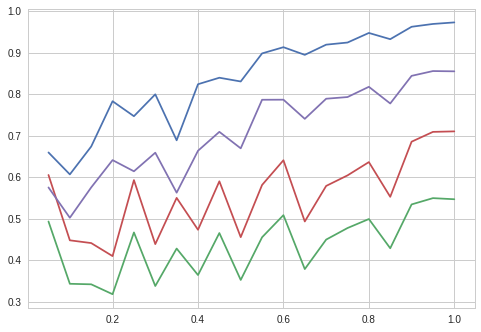

In [11]:
plt.plot(results['fraction'], results['lognormal_sign'])
plt.plot(results['fraction'], results['ztest_sign'])
plt.plot(results['fraction'], results['perm_test_sign'])
plt.plot(results['fraction'], results['CLT_sign'])

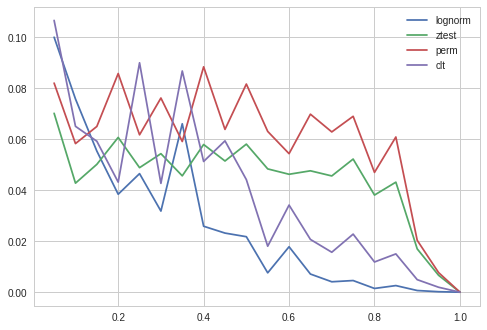

In [19]:
plt.plot(results['fraction'], results['lognormal_var'], label='lognorm')
plt.plot(results['fraction'], results['ztest_var'], label='ztest')
plt.plot(results['fraction'], results['perm_test_var'], label='perm')
plt.plot(results['fraction'], results['CLT_var'], label='clt')
plt.legend()

In [7]:
results = []
for frac in range(1, 21):
    print('Start bootstraping with sample fraction =', frac/20)
    signs = {
            'wald_signs': [],
        }
    
    for i in range(25):
        print('\tbootstrap_iter =', i)
        a_tmp = a.sample(frac=frac/20)
        b_tmp = b.sample(frac=frac/20)
        model = WaldABModel(a_tmp, b_tmp)
        model.fit()
        signs['wald_signs'].append(np.mean(model.trace['$\\Delta_{\\mu}$'] > 0))
    
    result = {
            'wald_sign': np.mean(signs['wald_signs']),
            'wald_var': np.var(signs['wald_signs']),
        }
    print(result)
    results.append(result)
#a.sample(frac=frac)

Start bootstraping with sample fraction = 0.05
	bootstrap_iter = 0
         Current function value: 20131.429668
         Iterations: 39
         Function evaluations: 96
         Gradient evaluations: 84


100%|██████████| 10000/10000 [00:03<00:00, 2651.64it/s]


	bootstrap_iter = 1
         Current function value: 20689.255431
         Iterations: 39
         Function evaluations: 128
         Gradient evaluations: 116


100%|██████████| 10000/10000 [00:04<00:00, 2376.18it/s]


	bootstrap_iter = 2
         Current function value: 20329.357728
         Iterations: 44
         Function evaluations: 200
         Gradient evaluations: 188


100%|██████████| 10000/10000 [00:04<00:00, 2471.68it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 20295.849907
         Iterations: 52
         Function evaluations: 71
         Gradient evaluations: 71


100%|██████████| 10000/10000 [00:03<00:00, 2533.25it/s]


	bootstrap_iter = 4
         Current function value: 20365.851968
         Iterations: 49
         Function evaluations: 148
         Gradient evaluations: 136


100%|██████████| 10000/10000 [00:04<00:00, 2403.36it/s]


	bootstrap_iter = 5
         Current function value: 20218.062625
         Iterations: 42
         Function evaluations: 122
         Gradient evaluations: 111


100%|██████████| 10000/10000 [00:04<00:00, 2417.47it/s]


	bootstrap_iter = 6
         Current function value: 20259.222982
         Iterations: 41
         Function evaluations: 189
         Gradient evaluations: 176


100%|██████████| 10000/10000 [00:04<00:00, 2337.23it/s]


	bootstrap_iter = 7
         Current function value: 20306.867866
         Iterations: 47
         Function evaluations: 169
         Gradient evaluations: 158


100%|██████████| 10000/10000 [00:04<00:00, 2486.79it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 20168.567463
         Iterations: 49
         Function evaluations: 72
         Gradient evaluations: 72


100%|██████████| 10000/10000 [00:03<00:00, 2642.05it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 20306.432231
         Iterations: 38
         Function evaluations: 64
         Gradient evaluations: 64


100%|██████████| 10000/10000 [00:03<00:00, 2638.16it/s]


	bootstrap_iter = 10
         Current function value: 20061.324951
         Iterations: 45
         Function evaluations: 150
         Gradient evaluations: 139


100%|██████████| 10000/10000 [00:03<00:00, 2643.41it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 20429.006751


100%|██████████| 10000/10000 [00:04<00:00, 2337.01it/s]


         Iterations: 52
         Function evaluations: 135
         Gradient evaluations: 134
	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 20493.214031
         Iterations: 41
         Function evaluations: 70
         Gradient evaluations: 70

100%|██████████| 10000/10000 [00:03<00:00, 2636.87it/s]



	bootstrap_iter = 13
         Current function value: 20485.254841
         Iterations: 44
         Function evaluations: 252
         Gradient evaluations: 239


100%|██████████| 10000/10000 [00:04<00:00, 2295.85it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 20117.820046
         Iterations: 54
         Function evaluations: 90
         Gradient evaluations: 90


100%|██████████| 10000/10000 [00:04<00:00, 2309.59it/s]


	bootstrap_iter = 15
         Current function value: 20169.242791
         Iterations: 45
         Function evaluations: 140
         Gradient evaluations: 130


100%|██████████| 10000/10000 [00:04<00:00, 2296.20it/s]


	bootstrap_iter = 16
         Current function value: 20130.959856
         Iterations: 37
         Function evaluations: 260
         Gradient evaluations: 242


100%|██████████| 10000/10000 [00:04<00:00, 2452.78it/s]


	bootstrap_iter = 17
         Current function value: 20264.831133
         Iterations: 40


100%|██████████| 10000/10000 [00:04<00:00, 2251.93it/s]


         Function evaluations: 121
         Gradient evaluations: 109
	bootstrap_iter = 18
         Current function value: 20245.348573
         Iterations: 45
         Function evaluations: 165
         Gradient evaluations: 154


100%|██████████| 10000/10000 [00:04<00:00, 2271.66it/s]


	bootstrap_iter = 19
         Current function value: 20442.682387
         Iterations: 47
         Function evaluations: 121
         Gradient evaluations: 109


100%|██████████| 10000/10000 [00:04<00:00, 2280.82it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 20379.127657

100%|██████████| 10000/10000 [00:04<00:00, 2247.14it/s]



         Iterations: 39
         Function evaluations: 64
         Gradient evaluations: 64
	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 20322.990964

100%|██████████| 10000/10000 [00:04<00:00, 2275.88it/s]



         Iterations: 42
         Function evaluations: 70
         Gradient evaluations: 70
	bootstrap_iter = 22
         Current function value: 139277.089808
         Iterations: 6

100%|██████████| 10000/10000 [00:04<00:00, 2352.87it/s]



         Function evaluations: 31
         Gradient evaluations: 19
	bootstrap_iter = 23
         Current function value: 19938.408605
         Iterations: 37
         Function evaluations: 130
         Gradient evaluations: 120


100%|██████████| 10000/10000 [00:04<00:00, 2333.42it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 20604.241785
         Iterations: 42
         Function evaluations: 65
         Gradient evaluations: 65


100%|██████████| 10000/10000 [00:04<00:00, 2243.89it/s]


{'wald_sign': 0.49646933333333332, 'wald_var': 0.00013643110399999992}
Start bootstraping with sample fraction = 0.1
	bootstrap_iter = 0


100%|██████████| 10000/10000 [00:05<00:00, 1882.29it/s]


         Current function value: 40731.983887
         Iterations: 43
         Function evaluations: 156
         Gradient evaluations: 143
	bootstrap_iter = 1
         Current function value: 241514.147281
         Iterations: 5
         Function evaluations: 29
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:05<00:00, 1943.66it/s]


	bootstrap_iter = 2
         Current function value: 1856119.441902
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:05<00:00, 1970.45it/s]


	bootstrap_iter = 3
         Current function value: 40485.472132
         Iterations: 47
         Function evaluations: 195
         Gradient evaluations: 180


100%|██████████| 10000/10000 [00:05<00:00, 1809.34it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 40405.952794
         Iterations: 52
         Function evaluations: 72
         Gradient evaluations: 72


100%|██████████| 10000/10000 [00:05<00:00, 1924.93it/s]


	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 40505.884761

100%|██████████| 10000/10000 [00:05<00:00, 1939.59it/s]



         Iterations: 45
         Function evaluations: 81
         Gradient evaluations: 81
	bootstrap_iter = 6
         Current function value: 156479.386242

100%|██████████| 10000/10000 [00:05<00:00, 1995.82it/s]



         Iterations: 5
         Function evaluations: 27
         Gradient evaluations: 15
	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 40343.679192
         Iterations: 45
         Function evaluations: 74
         Gradient evaluations: 74


100%|██████████| 10000/10000 [00:05<00:00, 1911.91it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 40059.514927
         Iterations: 40
         Function evaluations: 54
         Gradient evaluations: 54


100%|██████████| 10000/10000 [00:05<00:00, 1949.90it/s]


	bootstrap_iter = 9
         Current function value: 352308.288442
         Iterations: 5
         Function evaluations: 25
         Gradient evaluations: 13


100%|██████████| 10000/10000 [00:05<00:00, 1940.98it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 40262.945966
         Iterations: 44
         Function evaluations: 72
         Gradient evaluations: 72


100%|██████████| 10000/10000 [00:05<00:00, 1972.55it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 40869.746114
         Iterations: 44
         Function evaluations: 65

100%|██████████| 10000/10000 [00:05<00:00, 1900.06it/s]



         Gradient evaluations: 65
	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 40717.554439
         Iterations: 40
         Function evaluations: 61
         Gradient evaluations: 61


100%|██████████| 10000/10000 [00:04<00:00, 2154.31it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 40187.511100
         Iterations: 48
         Function evaluations: 87
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:05<00:00, 1917.00it/s]


	bootstrap_iter = 14
         Current function value: 40545.095377
         Iterations: 38
         Function evaluations: 120
         Gradient evaluations: 110


100%|██████████| 10000/10000 [00:05<00:00, 1915.59it/s]


	bootstrap_iter = 15
         Current function value: 40707.306546
         Iterations: 55
         Function evaluations: 153
         Gradient evaluations: 141


100%|██████████| 10000/10000 [00:05<00:00, 1723.75it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 40749.850886
         Iterations: 50
         Function evaluations: 71
         Gradient evaluations: 71

100%|██████████| 10000/10000 [00:05<00:00, 1954.43it/s]



	bootstrap_iter = 17
         Current function value: 40611.606279
         Iterations: 39
         Function evaluations: 149
         Gradient evaluations: 137


100%|██████████| 10000/10000 [00:05<00:00, 1935.21it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 40687.810895
         Iterations: 45
         Function evaluations: 113


100%|██████████| 10000/10000 [00:05<00:00, 1963.94it/s]


         Gradient evaluations: 110
	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 40897.521574
         Iterations: 43
         Function evaluations: 65
         Gradient evaluations: 65


100%|██████████| 10000/10000 [00:05<00:00, 1900.63it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 40645.344970
         Iterations: 42
         Function evaluations: 58
         Gradient evaluations: 58


100%|██████████| 10000/10000 [00:05<00:00, 1939.58it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 40117.838365
         Iterations: 54
         Function evaluations: 150
         Gradient evaluations: 149


100%|██████████| 10000/10000 [00:04<00:00, 2180.34it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 40599.286282
         Iterations: 53
         Function evaluations: 81
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:04<00:00, 2184.08it/s]


	bootstrap_iter = 23
         Current function value: 40656.867539
         Iterations: 60
         Function evaluations: 221
         Gradient evaluations: 208


100%|██████████| 10000/10000 [00:04<00:00, 2250.45it/s]


	bootstrap_iter = 24
         Current function value: 40752.550358
         Iterations: 41
         Function evaluations: 140
         Gradient evaluations: 128


100%|██████████| 10000/10000 [00:04<00:00, 2019.93it/s]


{'wald_sign': 0.4997813333333333, 'wald_var': 0.0001504567182222224}
Start bootstraping with sample fraction = 0.15
	bootstrap_iter = 0
         Current function value: 60986.215080
         Iterations: 41
         Function evaluations: 127
         Gradient evaluations: 115


100%|██████████| 10000/10000 [00:05<00:00, 1868.12it/s]


	bootstrap_iter = 1
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:05<00:00, 1672.21it/s]


         Current function value: 61210.069784
         Iterations: 43
         Function evaluations: 64
         Gradient evaluations: 64
	bootstrap_iter = 2
         Current function value: 61033.160199
         Iterations: 44
         Function evaluations: 194
         Gradient evaluations: 179


100%|██████████| 10000/10000 [00:05<00:00, 1673.16it/s]


	bootstrap_iter = 3
         Current function value: 61072.000912
         Iterations: 40


100%|██████████| 10000/10000 [00:05<00:00, 1720.55it/s]


         Function evaluations: 123
         Gradient evaluations: 111
	bootstrap_iter = 4
         Current function value: 959507.307722
         Iterations: 5
         Function evaluations: 25
         Gradient evaluations: 13


100%|██████████| 10000/10000 [00:05<00:00, 1734.94it/s]


	bootstrap_iter = 5
         Current function value: 60169.994807
         Iterations: 40
         Function evaluations: 136
         Gradient evaluations: 125


100%|██████████| 10000/10000 [00:05<00:00, 1701.54it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 60300.126572
         Iterations: 60
         Function evaluations: 97
         Gradient evaluations: 97


100%|██████████| 10000/10000 [00:05<00:00, 1783.17it/s]


	bootstrap_iter = 7
         Current function value: 239987.231983
         Iterations: 6
         Function evaluations: 32
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:05<00:00, 1696.40it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 61103.727363
         Iterations: 39
         Function evaluations: 70
         Gradient evaluations: 70


100%|██████████| 10000/10000 [00:05<00:00, 1726.98it/s]


	bootstrap_iter = 9
         Current function value: 61360.372716
         Iterations: 44
         Function evaluations: 150
         Gradient evaluations: 130


100%|██████████| 10000/10000 [00:06<00:00, 1653.45it/s]


	bootstrap_iter = 10
         Current function value: 61097.026016
         Iterations: 58
         Function evaluations: 179
         Gradient evaluations: 168


100%|██████████| 10000/10000 [00:05<00:00, 1737.36it/s]


	bootstrap_iter = 11
         Current function value: 61499.496840
         Iterations: 46
         Function evaluations: 322
         Gradient evaluations: 304


100%|██████████| 10000/10000 [00:06<00:00, 1651.38it/s]


	bootstrap_iter = 12
         Current function value: 60629.702244
         Iterations: 52
         Function evaluations: 153
         Gradient evaluations: 141


100%|██████████| 10000/10000 [00:06<00:00, 1648.34it/s]


	bootstrap_iter = 13
         Current function value: 61327.999630
         Iterations: 49
         Function evaluations: 170
         Gradient evaluations: 155


100%|██████████| 10000/10000 [00:05<00:00, 1721.53it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 61182.775441
         Iterations: 49
         Function evaluations: 70
         Gradient evaluations: 70


100%|██████████| 10000/10000 [00:05<00:00, 1691.68it/s]


	bootstrap_iter = 15


100%|██████████| 10000/10000 [00:05<00:00, 1728.45it/s]


         Current function value: 61149.139844
         Iterations: 32
         Function evaluations: 143
         Gradient evaluations: 133
	bootstrap_iter = 16
         Current function value: 60843.783442
         Iterations: 46
         Function evaluations: 249
         Gradient evaluations: 236


100%|██████████| 10000/10000 [00:05<00:00, 1715.31it/s]


	bootstrap_iter = 17
         Current function value: 60588.833396
         Iterations: 39
         Function evaluations: 109
         Gradient evaluations: 97


100%|██████████| 10000/10000 [00:05<00:00, 1720.30it/s]


	bootstrap_iter = 18
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:05<00:00, 1713.38it/s]


         Current function value: 60522.056700
         Iterations: 50
         Function evaluations: 77
         Gradient evaluations: 77
	bootstrap_iter = 19
         Current function value: 61211.003379
         Iterations: 51
         Function evaluations: 116
         Gradient evaluations: 104


100%|██████████| 10000/10000 [00:05<00:00, 1692.58it/s]


	bootstrap_iter = 20
         Current function value: 61500.779156
         Iterations: 40
         Function evaluations: 188
         Gradient evaluations: 174


100%|██████████| 10000/10000 [00:05<00:00, 1712.50it/s]


	bootstrap_iter = 21
         Current function value: 61843.584933
         Iterations: 52
         Function evaluations: 128
         Gradient evaluations: 117


100%|██████████| 10000/10000 [00:05<00:00, 1672.21it/s]


	bootstrap_iter = 22
         Current function value: 60665.932803
         Iterations: 51
         Function evaluations: 115
         Gradient evaluations: 104


100%|██████████| 10000/10000 [00:05<00:00, 1881.56it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 60542.358182
         Iterations: 51
         Function evaluations: 84
         Gradient evaluations: 84


100%|██████████| 10000/10000 [00:06<00:00, 1646.12it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 61484.157991
         Iterations: 47
         Function evaluations: 78
         Gradient evaluations: 78


100%|██████████| 10000/10000 [00:05<00:00, 1930.34it/s]


{'wald_sign': 0.49514666666666668, 'wald_var': 0.00014431715555555548}
Start bootstraping with sample fraction = 0.2
	bootstrap_iter = 0
         Current function value: 620030.298473
         Iterations: 6
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:06<00:00, 1521.55it/s]


	bootstrap_iter = 1
         Current function value: 81574.503043
         Iterations: 49
         Function evaluations: 188
         Gradient evaluations: 175


100%|██████████| 10000/10000 [00:06<00:00, 1537.75it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 81137.919996

100%|██████████| 10000/10000 [00:06<00:00, 1512.19it/s]



         Iterations: 42
         Function evaluations: 57
         Gradient evaluations: 57
	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 81032.626023
         Iterations: 55
         Function evaluations: 82
         Gradient evaluations: 82


100%|██████████| 10000/10000 [00:06<00:00, 1507.98it/s]


	bootstrap_iter = 4
         Current function value: 80407.395318

100%|██████████| 10000/10000 [00:06<00:00, 1541.02it/s]



         Iterations: 48
         Function evaluations: 236
         Gradient evaluations: 222
	bootstrap_iter = 5
         Current function value: 81396.543236
         Iterations: 56
         Function evaluations: 166
         Gradient evaluations: 155


100%|██████████| 10000/10000 [00:06<00:00, 1499.90it/s]


	bootstrap_iter = 6
         Current function value: 81712.183817
         Iterations: 56
         Function evaluations: 208
         Gradient evaluations: 197


100%|██████████| 10000/10000 [00:06<00:00, 1499.84it/s]


	bootstrap_iter = 7
         Current function value: 81056.560678
         Iterations: 55
         Function evaluations: 137
         Gradient evaluations: 127


100%|██████████| 10000/10000 [00:06<00:00, 1488.64it/s]


	bootstrap_iter = 8


100%|██████████| 10000/10000 [00:06<00:00, 1524.35it/s]


         Current function value: 5775678.511540
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5
	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 80913.875634
         Iterations: 43
         Function evaluations: 63
         Gradient evaluations: 63


100%|██████████| 10000/10000 [00:06<00:00, 1503.49it/s]


	bootstrap_iter = 10
         Current function value: 81117.424409
         Iterations: 47
         Function evaluations: 199
         Gradient evaluations: 184


100%|██████████| 10000/10000 [00:06<00:00, 1489.86it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 81139.828339
         Iterations: 40
         Function evaluations: 78
         Gradient evaluations: 78


100%|██████████| 10000/10000 [00:06<00:00, 1498.46it/s]


	bootstrap_iter = 12
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:06<00:00, 1500.58it/s]


         Current function value: 80732.833952
         Iterations: 57
         Function evaluations: 105
         Gradient evaluations: 105
	bootstrap_iter = 13
         Current function value: 3442698.030679
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:06<00:00, 1513.92it/s]


	bootstrap_iter = 14
         Current function value: 3274577.829177
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:06<00:00, 1525.95it/s]


	bootstrap_iter = 15
         Current function value: 80821.232579
         Iterations: 49
         Function evaluations: 117
         Gradient evaluations: 105


100%|██████████| 10000/10000 [00:06<00:00, 1503.53it/s]


	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 80580.921393
         Iterations: 44
         Function evaluations: 81
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:06<00:00, 1512.46it/s]


	bootstrap_iter = 17
         Current function value: 81527.830896
         Iterations: 41
         Function evaluations: 161
         Gradient evaluations: 148


100%|██████████| 10000/10000 [00:06<00:00, 1501.12it/s]


	bootstrap_iter = 18
         Current function value: 1271666.241308
         Iterations: 6
         Function evaluations: 36
         Gradient evaluations: 24


100%|██████████| 10000/10000 [00:06<00:00, 1530.01it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 80803.076796
         Iterations: 50
         Function evaluations: 132
         Gradient evaluations: 130


100%|██████████| 10000/10000 [00:06<00:00, 1499.68it/s]


	bootstrap_iter = 20
         Current function value: 81804.297587
         Iterations: 44
         Function evaluations: 199
         Gradient evaluations: 187


100%|██████████| 10000/10000 [00:06<00:00, 1517.32it/s]


	bootstrap_iter = 21
         Current function value: 6058038.157098
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:06<00:00, 1491.34it/s]


	bootstrap_iter = 22
Optimization terminated successfully.
         Current function value: 81206.664706
         Iterations: 45


100%|██████████| 10000/10000 [00:06<00:00, 1533.12it/s]


         Function evaluations: 84
         Gradient evaluations: 84
	bootstrap_iter = 23
         Current function value: 81597.248154
         Iterations: 45
         Function evaluations: 111
         Gradient evaluations: 100


100%|██████████| 10000/10000 [00:06<00:00, 1494.55it/s]


	bootstrap_iter = 24
         Current function value: 81123.560662
         Iterations: 49
         Function evaluations: 225
         Gradient evaluations: 211


100%|██████████| 10000/10000 [00:06<00:00, 1624.79it/s]


{'wald_sign': 0.50317866666666666, 'wald_var': 0.00011154158933333332}
Start bootstraping with sample fraction = 0.25
	bootstrap_iter = 0
         Current function value: 101742.809623
         Iterations: 53
         Function evaluations: 171
         Gradient evaluations: 159


100%|██████████| 10000/10000 [00:06<00:00, 1489.48it/s]


	bootstrap_iter = 1
         Current function value: 101287.917995
         Iterations: 57
         Function evaluations: 132
         Gradient evaluations: 122


100%|██████████| 10000/10000 [00:06<00:00, 1505.68it/s]


	bootstrap_iter = 2
         Current function value: 101720.003832
         Iterations: 48
         Function evaluations: 353
         Gradient evaluations: 336


100%|██████████| 10000/10000 [00:07<00:00, 1362.33it/s]


	bootstrap_iter = 3
         Current function value: 101526.414469
         Iterations: 43
         Function evaluations: 139
         Gradient evaluations: 128


100%|██████████| 10000/10000 [00:07<00:00, 1353.57it/s]


	bootstrap_iter = 4
         Current function value: 101301.560115
         Iterations: 49
         Function evaluations: 231
         Gradient evaluations: 217


100%|██████████| 10000/10000 [00:07<00:00, 1345.35it/s]


	bootstrap_iter = 5
         Current function value: 101596.624913
         Iterations: 52
         Function evaluations: 161
         Gradient evaluations: 150


100%|██████████| 10000/10000 [00:07<00:00, 1355.50it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 101588.213429
         Iterations: 37
         Function evaluations: 164
         Gradient evaluations: 161


100%|██████████| 10000/10000 [00:06<00:00, 1452.88it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 101630.423595
         Iterations: 48
         Function evaluations: 76
         Gradient evaluations: 76


100%|██████████| 10000/10000 [00:07<00:00, 1348.74it/s]


	bootstrap_iter = 8
         Current function value: 102250.322515
         Iterations: 50
         Function evaluations: 184
         Gradient evaluations: 171


100%|██████████| 10000/10000 [00:07<00:00, 1362.04it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 101762.976924
         Iterations: 53
         Function evaluations: 101
         Gradient evaluations: 90


100%|██████████| 10000/10000 [00:06<00:00, 1497.17it/s]


	bootstrap_iter = 10
Optimization terminated successfully.
         Current function value: 101535.593199
         Iterations: 52
         Function evaluations: 94
         Gradient evaluations: 94


100%|██████████| 10000/10000 [00:06<00:00, 1490.09it/s]


	bootstrap_iter = 11
         Current function value: 101541.815534
         Iterations: 44


100%|██████████| 10000/10000 [00:07<00:00, 1360.91it/s]


         Function evaluations: 106
         Gradient evaluations: 96
	bootstrap_iter = 12
         Current function value: 4833006.452292
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:07<00:00, 1395.43it/s]


	bootstrap_iter = 13
         Current function value: 101827.980113
         Iterations: 46
         Function evaluations: 146
         Gradient evaluations: 135


100%|██████████| 10000/10000 [00:07<00:00, 1371.25it/s]


	bootstrap_iter = 14
         Current function value: 2237726.068452
         Iterations: 6
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:07<00:00, 1393.83it/s]


	bootstrap_iter = 15
         Current function value: 101279.713031
         Iterations: 50
         Function evaluations: 191


100%|██████████| 10000/10000 [00:07<00:00, 1332.73it/s]


         Gradient evaluations: 178
	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 101602.982579
         Iterations: 52
         Function evaluations: 122
         Gradient evaluations: 121


100%|██████████| 10000/10000 [00:07<00:00, 1377.81it/s]


	bootstrap_iter = 17
Optimization terminated successfully.
         Current function value: 101125.134868
         Iterations: 53
         Function evaluations: 201
         Gradient evaluations: 199


100%|██████████| 10000/10000 [00:07<00:00, 1375.35it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 101309.062124
         Iterations: 53
         Function evaluations: 90
         Gradient evaluations: 90


100%|██████████| 10000/10000 [00:07<00:00, 1376.96it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 101336.707405
         Iterations: 41
         Function evaluations: 61
         Gradient evaluations: 61


100%|██████████| 10000/10000 [00:07<00:00, 1360.77it/s]


	bootstrap_iter = 20
         Current function value: 101779.958907
         Iterations: 48
         Function evaluations: 132
         Gradient evaluations: 120


100%|██████████| 10000/10000 [00:07<00:00, 1370.58it/s]


	bootstrap_iter = 21
         Current function value: 101316.904009
         Iterations: 42
         Function evaluations: 137
         Gradient evaluations: 126


100%|██████████| 10000/10000 [00:07<00:00, 1345.88it/s]


	bootstrap_iter = 22
         Current function value: 102537.599007
         Iterations: 51
         Function evaluations: 120
         Gradient evaluations: 108


100%|██████████| 10000/10000 [00:07<00:00, 1360.82it/s]


	bootstrap_iter = 23
         Current function value: 101409.100693
         Iterations: 40
         Function evaluations: 151
         Gradient evaluations: 138


100%|██████████| 10000/10000 [00:07<00:00, 1340.68it/s]


	bootstrap_iter = 24
         Current function value: 7270253.612102
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:06<00:00, 1439.79it/s]


{'wald_sign': 0.50504533333333335, 'wald_var': 0.00017714158933333334}
Start bootstraping with sample fraction = 0.3
	bootstrap_iter = 0
         Current function value: 121618.145514
         Iterations: 43
         Function evaluations: 146
         Gradient evaluations: 134


100%|██████████| 10000/10000 [00:07<00:00, 1375.46it/s]


	bootstrap_iter = 1
         Current function value: 122175.959533
         Iterations: 56
         Function evaluations: 214
         Gradient evaluations: 200


100%|██████████| 10000/10000 [00:07<00:00, 1361.87it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 121885.010682
         Iterations: 62
         Function evaluations: 90
         Gradient evaluations: 90


100%|██████████| 10000/10000 [00:07<00:00, 1251.11it/s]


	bootstrap_iter = 3


100%|██████████| 10000/10000 [00:08<00:00, 1233.98it/s]


         Current function value: 4539060.510840
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5
	bootstrap_iter = 4
         Current function value: 121554.614374
         Iterations: 45
         Function evaluations: 158
         Gradient evaluations: 147


100%|██████████| 10000/10000 [00:08<00:00, 1238.41it/s]


	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 122418.408690
         Iterations: 48
         Function evaluations: 108
         Gradient evaluations: 106


100%|██████████| 10000/10000 [00:08<00:00, 1227.67it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 121846.525600
         Iterations: 50
         Function evaluations: 81
         Gradient evaluations: 81


100%|██████████| 10000/10000 [00:08<00:00, 1248.35it/s]


	bootstrap_iter = 7
         Current function value: 818677.252811
         Iterations: 5
         Function evaluations: 25
         Gradient evaluations: 13


100%|██████████| 10000/10000 [00:08<00:00, 1225.11it/s]


	bootstrap_iter = 8
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:08<00:00, 1216.57it/s]


         Current function value: 121705.660782
         Iterations: 41
         Function evaluations: 55
         Gradient evaluations: 55
	bootstrap_iter = 9
         Current function value: 121994.642790
         Iterations: 46
         Function evaluations: 156
         Gradient evaluations: 145


100%|██████████| 10000/10000 [00:07<00:00, 1252.77it/s]


	bootstrap_iter = 10
         Current function value: 121739.548304
         Iterations: 48
         Function evaluations: 190
         Gradient evaluations: 179


100%|██████████| 10000/10000 [00:08<00:00, 1248.26it/s]


	bootstrap_iter = 11


100%|██████████| 10000/10000 [00:08<00:00, 1224.91it/s]


         Current function value: 121197.821476
         Iterations: 49
         Function evaluations: 209
         Gradient evaluations: 195
	bootstrap_iter = 12


100%|██████████| 10000/10000 [00:08<00:00, 1235.89it/s]


         Current function value: 1058684.975402
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 12
	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 122136.679158
         Iterations: 49
         Function evaluations: 78
         Gradient evaluations: 78


100%|██████████| 10000/10000 [00:08<00:00, 1240.44it/s]


	bootstrap_iter = 14
         Current function value: 122425.337406
         Iterations: 51
         Function evaluations: 159
         Gradient evaluations: 148


100%|██████████| 10000/10000 [00:08<00:00, 1218.50it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 121410.067699
         Iterations: 48
         Function evaluations: 66
         Gradient evaluations: 66


100%|██████████| 10000/10000 [00:08<00:00, 1249.54it/s]


	bootstrap_iter = 16
         Current function value: 121312.648820
         Iterations: 38

100%|██████████| 10000/10000 [00:08<00:00, 1230.25it/s]



         Function evaluations: 108
         Gradient evaluations: 96
	bootstrap_iter = 17
         Current function value: 121675.077136
         Iterations: 45
         Function evaluations: 147
         Gradient evaluations: 138


100%|██████████| 10000/10000 [00:08<00:00, 1237.39it/s]


	bootstrap_iter = 18
         Current function value: 122016.359833
         Iterations: 51


100%|██████████| 10000/10000 [00:08<00:00, 1243.43it/s]


         Function evaluations: 227
         Gradient evaluations: 216
	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 121429.813351
         Iterations: 60
         Function evaluations: 139
         Gradient evaluations: 138


100%|██████████| 10000/10000 [00:08<00:00, 1240.44it/s]


	bootstrap_iter = 20
         Current function value: 121808.800804
         Iterations: 63
         Function evaluations: 277
         Gradient evaluations: 263


100%|██████████| 10000/10000 [00:07<00:00, 1259.78it/s]


	bootstrap_iter = 21
         Current function value: 121904.654858
         Iterations: 49
         Function evaluations: 179
         Gradient evaluations: 167


100%|██████████| 10000/10000 [00:08<00:00, 1226.31it/s]


	bootstrap_iter = 22
         Current function value: 121806.669986
         Iterations: 40
         Function evaluations: 189
         Gradient evaluations: 176


100%|██████████| 10000/10000 [00:08<00:00, 1239.66it/s]


	bootstrap_iter = 23
         Current function value: 121572.947442
         Iterations: 49
         Function evaluations: 158
         Gradient evaluations: 146


100%|██████████| 10000/10000 [00:08<00:00, 1241.40it/s]


	bootstrap_iter = 24
         Current function value: 121525.420228
         Iterations: 53
         Function evaluations: 173

100%|██████████| 10000/10000 [00:07<00:00, 1250.34it/s]



         Gradient evaluations: 158
{'wald_sign': 0.50204266666666664, 'wald_var': 0.00016450520177777779}
Start bootstraping with sample fraction = 0.35
	bootstrap_iter = 0
         Current function value: 142089.337621
         Iterations: 52
         Function evaluations: 139
         Gradient evaluations: 129


100%|██████████| 10000/10000 [00:08<00:00, 1154.66it/s]


	bootstrap_iter = 1
         Current function value: 141913.322175
         Iterations: 54
         Function evaluations: 297
         Gradient evaluations: 282


100%|██████████| 10000/10000 [00:08<00:00, 1122.66it/s]


	bootstrap_iter = 2


100%|██████████| 10000/10000 [00:08<00:00, 1147.20it/s]


         Current function value: 142118.156131
         Iterations: 59
         Function evaluations: 248
         Gradient evaluations: 235
	bootstrap_iter = 3
         Current function value: 8057602.766570
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:08<00:00, 1127.74it/s]


	bootstrap_iter = 4
Optimization terminated successfully.
         Current function value: 142010.555370
         Iterations: 60
         Function evaluations: 91
         Gradient evaluations: 91


100%|██████████| 10000/10000 [00:08<00:00, 1141.02it/s]


	bootstrap_iter = 5
         Current function value: 142007.617048
         Iterations: 50
         Function evaluations: 156
         Gradient evaluations: 145

100%|██████████| 10000/10000 [00:08<00:00, 1132.24it/s]



	bootstrap_iter = 6
         Current function value: 142453.757232
         Iterations: 53
         Function evaluations: 144
         Gradient evaluations: 132


100%|██████████| 10000/10000 [00:08<00:00, 1132.28it/s]


	bootstrap_iter = 7


100%|██████████| 10000/10000 [00:08<00:00, 1150.55it/s]


         Current function value: 141868.442420
         Iterations: 52
         Function evaluations: 157
         Gradient evaluations: 146
	bootstrap_iter = 8
         Current function value: 1164656.952923
         Iterations: 7
         Function evaluations: 31
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:08<00:00, 1127.19it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 142066.200764
         Iterations: 47
         Function evaluations: 71
         Gradient evaluations: 71


100%|██████████| 10000/10000 [00:08<00:00, 1124.42it/s]


	bootstrap_iter = 10
         Current function value: 142142.791077
         Iterations: 42
         Function evaluations: 202
         Gradient evaluations: 188


100%|██████████| 10000/10000 [00:08<00:00, 1130.68it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 141955.566026
         Iterations: 54

100%|██████████| 10000/10000 [00:08<00:00, 1121.78it/s]



         Function evaluations: 88
         Gradient evaluations: 88
	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 142095.971120
         Iterations: 58
         Function evaluations: 105
         Gradient evaluations: 105


100%|██████████| 10000/10000 [00:08<00:00, 1238.29it/s]


	bootstrap_iter = 13
         Current function value: 141858.384886
         Iterations: 46
         Function evaluations: 181
         Gradient evaluations: 168


100%|██████████| 10000/10000 [00:08<00:00, 1215.52it/s]


	bootstrap_iter = 14
         Current function value: 525275.259318
         Iterations: 5
         Function evaluations: 32
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:08<00:00, 1151.62it/s]


	bootstrap_iter = 15
         Current function value: 142549.920913
         Iterations: 50
         Function evaluations: 156
         Gradient evaluations: 143


100%|██████████| 10000/10000 [00:08<00:00, 1129.26it/s]


	bootstrap_iter = 16
         Current function value: 141362.129224
         Iterations: 46


100%|██████████| 10000/10000 [00:08<00:00, 1163.78it/s]


         Function evaluations: 131
         Gradient evaluations: 120
	bootstrap_iter = 17
         Current function value: 142424.460334
         Iterations: 57
         Function evaluations: 165
         Gradient evaluations: 154


100%|██████████| 10000/10000 [00:08<00:00, 1234.21it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 143462.774258
         Iterations: 46
         Function evaluations: 113
         Gradient evaluations: 111


100%|██████████| 10000/10000 [00:08<00:00, 1128.37it/s]


	bootstrap_iter = 19
         Current function value: 142890.625873
         Iterations: 49
         Function evaluations: 194
         Gradient evaluations: 179


100%|██████████| 10000/10000 [00:08<00:00, 1151.08it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 141907.020696

100%|██████████| 10000/10000 [00:08<00:00, 1131.26it/s]



         Iterations: 51
         Function evaluations: 139
         Gradient evaluations: 137
	bootstrap_iter = 21
         Current function value: 141949.882470
         Iterations: 47
         Function evaluations: 163
         Gradient evaluations: 151


100%|██████████| 10000/10000 [00:08<00:00, 1123.41it/s]


	bootstrap_iter = 22
         Current function value: 142086.856976
         Iterations: 53
         Function evaluations: 143
         Gradient evaluations: 131


100%|██████████| 10000/10000 [00:08<00:00, 1124.27it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 141768.057987
         Iterations: 53
         Function evaluations: 80
         Gradient evaluations: 80


100%|██████████| 10000/10000 [00:08<00:00, 1185.31it/s]


	bootstrap_iter = 24
         Current function value: 142979.580068
         Iterations: 43
         Function evaluations: 156
         Gradient evaluations: 144


100%|██████████| 10000/10000 [00:08<00:00, 1148.65it/s]


{'wald_sign': 0.49839466666666665, 'wald_var': 0.00020159783822222221}
Start bootstraping with sample fraction = 0.4
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 162758.734137
         Iterations: 51
         Function evaluations: 87
         Gradient evaluations: 87


100%|██████████| 10000/10000 [00:09<00:00, 1051.57it/s]


	bootstrap_iter = 1
         Current function value: 162117.807874
         Iterations: 47
         Function evaluations: 128
         Gradient evaluations: 117


100%|██████████| 10000/10000 [00:09<00:00, 1048.94it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 162435.583329
         Iterations: 49
         Function evaluations: 210
         Gradient evaluations: 206


100%|██████████| 10000/10000 [00:09<00:00, 1041.66it/s]


	bootstrap_iter = 3
         Current function value: 162807.872578
         Iterations: 54
         Function evaluations: 272
         Gradient evaluations: 256


100%|██████████| 10000/10000 [00:09<00:00, 1025.29it/s]


	bootstrap_iter = 4


100%|██████████| 10000/10000 [00:09<00:00, 1071.11it/s]


         Current function value: 162692.614264
         Iterations: 56
         Function evaluations: 144
         Gradient evaluations: 133
	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 162230.313553
         Iterations: 57
         Function evaluations: 141
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:09<00:00, 1021.15it/s]


	bootstrap_iter = 6
         Current function value: 162287.296755
         Iterations: 58


100%|██████████| 10000/10000 [00:08<00:00, 1113.11it/s]


         Function evaluations: 191
         Gradient evaluations: 179
	bootstrap_iter = 7
         Current function value: 162907.557997
         Iterations: 52
         Function evaluations: 142
         Gradient evaluations: 133


100%|██████████| 10000/10000 [00:08<00:00, 1151.65it/s]


	bootstrap_iter = 8
         Current function value: 10219861.783083
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:09<00:00, 1030.43it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 162123.602019
         Iterations: 62
         Function evaluations: 90
         Gradient evaluations: 90


100%|██████████| 10000/10000 [00:09<00:00, 1065.75it/s]


	bootstrap_iter = 10
         Current function value: 162059.219675
         Iterations: 49
         Function evaluations: 195
         Gradient evaluations: 181


100%|██████████| 10000/10000 [00:09<00:00, 1048.83it/s]


	bootstrap_iter = 11
         Current function value: 162057.687227
         Iterations: 44
         Function evaluations: 131
         Gradient evaluations: 119


100%|██████████| 10000/10000 [00:09<00:00, 1060.19it/s]


	bootstrap_iter = 12
         Current function value: 11558784.545595
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:09<00:00, 1041.02it/s]


	bootstrap_iter = 13
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:09<00:00, 1047.66it/s]


         Current function value: 162199.673654
         Iterations: 41
         Function evaluations: 112
         Gradient evaluations: 110
	bootstrap_iter = 14
         Current function value: 162415.507898
         Iterations: 46


100%|██████████| 10000/10000 [00:09<00:00, 1067.88it/s]


         Function evaluations: 171
         Gradient evaluations: 162
	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 162013.501856
         Iterations: 63
         Function evaluations: 108
         Gradient evaluations: 108


100%|██████████| 10000/10000 [00:09<00:00, 1046.68it/s]


	bootstrap_iter = 16
         Current function value: 162247.742961
         Iterations: 46
         Function evaluations: 133
         Gradient evaluations: 123


100%|██████████| 10000/10000 [00:09<00:00, 1072.19it/s]


	bootstrap_iter = 17
         Current function value: 3471933.743938

100%|██████████| 10000/10000 [00:09<00:00, 1047.42it/s]



         Iterations: 5
         Function evaluations: 26
         Gradient evaluations: 14
	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 162457.859366
         Iterations: 54
         Function evaluations: 190
         Gradient evaluations: 184


100%|██████████| 10000/10000 [00:09<00:00, 1054.64it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 162308.135271
         Iterations: 50

100%|██████████| 10000/10000 [00:09<00:00, 1068.08it/s]



         Function evaluations: 70
         Gradient evaluations: 70
	bootstrap_iter = 20
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:09<00:00, 1062.19it/s]


         Current function value: 162318.414025
         Iterations: 48
         Function evaluations: 145
         Gradient evaluations: 144
	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 162478.573239
         Iterations: 50
         Function evaluations: 238
         Gradient evaluations: 234


100%|██████████| 10000/10000 [00:09<00:00, 1058.24it/s]


	bootstrap_iter = 22
         Current function value: 162538.834357
         Iterations: 55
         Function evaluations: 169
         Gradient evaluations: 158


100%|██████████| 10000/10000 [00:09<00:00, 1048.69it/s]


	bootstrap_iter = 23
         Current function value: 2566760.259349
         Iterations: 5
         Function evaluations: 25
         Gradient evaluations: 13


100%|██████████| 10000/10000 [00:09<00:00, 1057.45it/s]


	bootstrap_iter = 24
         Current function value: 4713380.572575
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:09<00:00, 1062.55it/s]


{'wald_sign': 0.50225066666666673, 'wald_var': 0.00012522569955555551}
Start bootstraping with sample fraction = 0.45
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 183185.952768
         Iterations: 45
         Function evaluations: 59
         Gradient evaluations: 59


100%|██████████| 10000/10000 [00:10<00:00, 970.77it/s]


	bootstrap_iter = 1
         Current function value: 182858.479325
         Iterations: 54
         Function evaluations: 186
         Gradient evaluations: 164


100%|██████████| 10000/10000 [00:09<00:00, 1029.63it/s]


	bootstrap_iter = 2
         Current function value: 8092137.032094
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:10<00:00, 972.02it/s]


	bootstrap_iter = 3
         Current function value: 183160.862999
         Iterations: 44
         Function evaluations: 143
         Gradient evaluations: 132


100%|██████████| 10000/10000 [00:10<00:00, 976.84it/s]


	bootstrap_iter = 4
         Current function value: 182340.229560
         Iterations: 47
         Function evaluations: 145
         Gradient evaluations: 133


100%|██████████| 10000/10000 [00:10<00:00, 981.12it/s]


	bootstrap_iter = 5
         Current function value: 13042152.937160
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:10<00:00, 974.81it/s]


	bootstrap_iter = 6
         Current function value: 183461.335246
         Iterations: 41
         Function evaluations: 203
         Gradient evaluations: 189


100%|██████████| 10000/10000 [00:10<00:00, 975.73it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 183152.136348
         Iterations: 47
         Function evaluations: 71
         Gradient evaluations: 71


100%|██████████| 10000/10000 [00:10<00:00, 988.79it/s]


	bootstrap_iter = 8
         Current function value: 10960383.041735
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:10<00:00, 986.23it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 182251.068568
         Iterations: 54
         Function evaluations: 89
         Gradient evaluations: 89


100%|██████████| 10000/10000 [00:10<00:00, 979.67it/s]


	bootstrap_iter = 10
         Current function value: 183285.044384
         Iterations: 45
         Function evaluations: 147
         Gradient evaluations: 136


100%|██████████| 10000/10000 [00:10<00:00, 986.65it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 182950.018050
         Iterations: 53
         Function evaluations: 73
         Gradient evaluations: 73


100%|██████████| 10000/10000 [00:10<00:00, 972.56it/s]


	bootstrap_iter = 12
         Current function value: 11040862.176457
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:10<00:00, 980.06it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 182915.962411
         Iterations: 50
         Function evaluations: 146
         Gradient evaluations: 145


100%|██████████| 10000/10000 [00:10<00:00, 989.18it/s]


	bootstrap_iter = 14
         Current function value: 181946.253663
         Iterations: 55
         Function evaluations: 152
         Gradient evaluations: 141


100%|██████████| 10000/10000 [00:10<00:00, 980.47it/s]


	bootstrap_iter = 15
         Current function value: 182501.271004
         Iterations: 51
         Function evaluations: 156
         Gradient evaluations: 144


100%|██████████| 10000/10000 [00:10<00:00, 981.09it/s]


	bootstrap_iter = 16
         Current function value: 182503.588843
         Iterations: 44
         Function evaluations: 152
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:10<00:00, 964.84it/s]


	bootstrap_iter = 17
         Current function value: 183006.593301
         Iterations: 49
         Function evaluations: 149
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:10<00:00, 982.42it/s]


	bootstrap_iter = 18
         Current function value: 182790.358298
         Iterations: 52
         Function evaluations: 141
         Gradient evaluations: 130


100%|██████████| 10000/10000 [00:10<00:00, 989.32it/s]


	bootstrap_iter = 19
         Current function value: 182129.078613
         Iterations: 57
         Function evaluations: 365
         Gradient evaluations: 344


100%|██████████| 10000/10000 [00:09<00:00, 1059.09it/s]


	bootstrap_iter = 20
         Current function value: 182714.784868
         Iterations: 58
         Function evaluations: 243
         Gradient evaluations: 230


100%|██████████| 10000/10000 [00:09<00:00, 1070.63it/s]


	bootstrap_iter = 21
         Current function value: 182531.353054
         Iterations: 44
         Function evaluations: 150
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:09<00:00, 1068.33it/s]


	bootstrap_iter = 22
         Current function value: 181989.599583
         Iterations: 51
         Function evaluations: 142
         Gradient evaluations: 130


100%|██████████| 10000/10000 [00:10<00:00, 979.60it/s]


	bootstrap_iter = 23
         Current function value: 1801532.768459
         Iterations: 5
         Function evaluations: 32
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:10<00:00, 986.92it/s]


	bootstrap_iter = 24
         Current function value: 4808314.107919
         Iterations: 6
         Function evaluations: 32
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:10<00:00, 978.35it/s]


{'wald_sign': 0.50152533333333327, 'wald_var': 0.00012931851377777785}
Start bootstraping with sample fraction = 0.5
	bootstrap_iter = 0
         Current function value: 202471.523466

100%|██████████| 10000/10000 [00:10<00:00, 920.09it/s]



         Iterations: 52
         Function evaluations: 198
         Gradient evaluations: 181
	bootstrap_iter = 1
         Current function value: 202516.312009
         Iterations: 58
         Function evaluations: 169
         Gradient evaluations: 158


100%|██████████| 10000/10000 [00:10<00:00, 920.65it/s]


	bootstrap_iter = 2


100%|██████████| 10000/10000 [00:10<00:00, 914.53it/s]


         Current function value: 203564.863582
         Iterations: 48
         Function evaluations: 201
         Gradient evaluations: 186
	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 203164.202159
         Iterations: 47


100%|██████████| 10000/10000 [00:10<00:00, 920.08it/s]


         Function evaluations: 123
         Gradient evaluations: 122
	bootstrap_iter = 4
         Current function value: 12583748.456491
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:10<00:00, 915.46it/s]


	bootstrap_iter = 5
         Current function value: 202600.891490
         Iterations: 52
         Function evaluations: 175
         Gradient evaluations: 163


100%|██████████| 10000/10000 [00:10<00:00, 913.51it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 203196.384609
         Iterations: 53
         Function evaluations: 85
         Gradient evaluations: 85


100%|██████████| 10000/10000 [00:10<00:00, 918.76it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 202786.155719
         Iterations: 51
         Function evaluations: 77
         Gradient evaluations: 77


100%|██████████| 10000/10000 [00:10<00:00, 921.95it/s]


	bootstrap_iter = 8
         Current function value: 202879.895420
         Iterations: 54
         Function evaluations: 186
         Gradient evaluations: 172


100%|██████████| 10000/10000 [00:10<00:00, 919.55it/s]


	bootstrap_iter = 9
Optimization terminated successfully.
         Current function value: 203158.157456
         Iterations: 51
         Function evaluations: 74
         Gradient evaluations: 74


100%|██████████| 10000/10000 [00:10<00:00, 923.43it/s]


	bootstrap_iter = 10
         Current function value: 202410.240706
         Iterations: 50
         Function evaluations: 240
         Gradient evaluations: 225


100%|██████████| 10000/10000 [00:10<00:00, 930.12it/s]


	bootstrap_iter = 11
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:10<00:00, 918.32it/s]


         Current function value: 202928.698435
         Iterations: 50
         Function evaluations: 72
         Gradient evaluations: 72
	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 202992.089757
         Iterations: 59
         Function evaluations: 79
         Gradient evaluations: 79


100%|██████████| 10000/10000 [00:10<00:00, 914.36it/s]


	bootstrap_iter = 13
         Current function value: 203086.655842
         Iterations: 47


100%|██████████| 10000/10000 [00:10<00:00, 924.17it/s]


         Function evaluations: 155
         Gradient evaluations: 143
	bootstrap_iter = 14
         Current function value: 14853357.206615
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:10<00:00, 918.34it/s]


	bootstrap_iter = 15


100%|██████████| 10000/10000 [00:10<00:00, 919.77it/s]


         Current function value: 203160.585336
         Iterations: 45
         Function evaluations: 146
         Gradient evaluations: 136
	bootstrap_iter = 16
Optimization terminated successfully.
         Current function value: 203150.537138
         Iterations: 52
         Function evaluations: 85
         Gradient evaluations: 85


100%|██████████| 10000/10000 [00:10<00:00, 913.79it/s]


	bootstrap_iter = 17
         Current function value: 203887.511284
         Iterations: 51
         Function evaluations: 251
         Gradient evaluations: 237


100%|██████████| 10000/10000 [00:11<00:00, 904.82it/s]


	bootstrap_iter = 18


100%|██████████| 10000/10000 [00:10<00:00, 923.92it/s]


         Current function value: 202964.763207
         Iterations: 45
         Function evaluations: 138
         Gradient evaluations: 128
	bootstrap_iter = 19
         Current function value: 14512937.504475
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:10<00:00, 921.21it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 203896.148535
         Iterations: 58


100%|██████████| 10000/10000 [00:10<00:00, 924.62it/s]


         Function evaluations: 95
         Gradient evaluations: 95
	bootstrap_iter = 21
         Current function value: 203003.129711
         Iterations: 43
         Function evaluations: 141
         Gradient evaluations: 129


100%|██████████| 10000/10000 [00:10<00:00, 934.35it/s]


	bootstrap_iter = 22
         Current function value: 202292.792476
         Iterations: 45
         Function evaluations: 139
         Gradient evaluations: 128


100%|██████████| 10000/10000 [00:10<00:00, 914.46it/s]


	bootstrap_iter = 23
         Current function value: 14797369.085634
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:10<00:00, 918.52it/s]


	bootstrap_iter = 24
         Current function value: 202894.887873
         Iterations: 45
         Function evaluations: 216
         Gradient evaluations: 203


100%|██████████| 10000/10000 [00:10<00:00, 920.32it/s]


{'wald_sign': 0.49955733333333335, 'wald_var': 0.00011035409066666665}
Start bootstraping with sample fraction = 0.55
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 222847.207910
         Iterations: 49
         Function evaluations: 74
         Gradient evaluations: 74


100%|██████████| 10000/10000 [00:11<00:00, 871.32it/s]


	bootstrap_iter = 1
         Current function value: 224274.206677
         Iterations: 41
         Function evaluations: 136
         Gradient evaluations: 125


100%|██████████| 10000/10000 [00:11<00:00, 865.28it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 222608.492503
         Iterations: 57
         Function evaluations: 143
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:11<00:00, 858.98it/s]


	bootstrap_iter = 3


100%|██████████| 10000/10000 [00:11<00:00, 864.47it/s]


         Current function value: 9701917.845784
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5
	bootstrap_iter = 4
         Current function value: 223189.628006
         Iterations: 49


100%|██████████| 10000/10000 [00:11<00:00, 853.40it/s]


         Function evaluations: 148
         Gradient evaluations: 137
	bootstrap_iter = 5
         Current function value: 222951.109395
         Iterations: 47
         Function evaluations: 134
         Gradient evaluations: 123


100%|██████████| 10000/10000 [00:10<00:00, 921.63it/s]


	bootstrap_iter = 6
         Current function value: 16108370.033202
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:11<00:00, 889.41it/s]


	bootstrap_iter = 7
         Current function value: 223311.080434
         Iterations: 45
         Function evaluations: 164
         Gradient evaluations: 153


100%|██████████| 10000/10000 [00:11<00:00, 860.59it/s]


	bootstrap_iter = 8
         Current function value: 5286617.835594
         Iterations: 4


100%|██████████| 10000/10000 [00:11<00:00, 866.38it/s]


         Function evaluations: 33
         Gradient evaluations: 21
	bootstrap_iter = 9


100%|██████████| 10000/10000 [00:11<00:00, 867.38it/s]


         Current function value: 223257.838960
         Iterations: 69
         Function evaluations: 283
         Gradient evaluations: 272
	bootstrap_iter = 10
         Current function value: 6979833.260020
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:11<00:00, 840.07it/s]


	bootstrap_iter = 11
         Current function value: 223667.320763
         Iterations: 53
         Function evaluations: 132
         Gradient evaluations: 120


100%|██████████| 10000/10000 [00:10<00:00, 933.36it/s]


	bootstrap_iter = 12
Optimization terminated successfully.
         Current function value: 223118.001252
         Iterations: 55
         Function evaluations: 83
         Gradient evaluations: 83


100%|██████████| 10000/10000 [00:10<00:00, 932.02it/s]


	bootstrap_iter = 13
         Current function value: 223675.094284
         Iterations: 47
         Function evaluations: 158
         Gradient evaluations: 146


100%|██████████| 10000/10000 [00:11<00:00, 877.15it/s]


	bootstrap_iter = 14
         Current function value: 223552.281297
         Iterations: 58
         Function evaluations: 173
         Gradient evaluations: 163


100%|██████████| 10000/10000 [00:11<00:00, 857.69it/s]


	bootstrap_iter = 15
         Current function value: 5998118.878852
         Iterations: 4


100%|██████████| 10000/10000 [00:11<00:00, 874.30it/s]


         Function evaluations: 26
         Gradient evaluations: 14
	bootstrap_iter = 16
         Current function value: 223351.270188
         Iterations: 53
         Function evaluations: 128
         Gradient evaluations: 117


100%|██████████| 10000/10000 [00:12<00:00, 828.23it/s]


	bootstrap_iter = 17
         Current function value: 223484.218829
         Iterations: 55
         Function evaluations: 165
         Gradient evaluations: 154


100%|██████████| 10000/10000 [00:11<00:00, 881.97it/s]


	bootstrap_iter = 18
         Current function value: 222729.724487
         Iterations: 58
         Function evaluations: 295

100%|██████████| 10000/10000 [00:11<00:00, 865.86it/s]



         Gradient evaluations: 281
	bootstrap_iter = 19
         Current function value: 223828.718077
         Iterations: 44
         Function evaluations: 127
         Gradient evaluations: 116


100%|██████████| 10000/10000 [00:10<00:00, 913.27it/s]


	bootstrap_iter = 20
         Current function value: 223870.756522
         Iterations: 59
         Function evaluations: 163
         Gradient evaluations: 151


100%|██████████| 10000/10000 [00:10<00:00, 941.45it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 223170.259318
         Iterations: 47
         Function evaluations: 62
         Gradient evaluations: 62


100%|██████████| 10000/10000 [00:11<00:00, 854.27it/s]


	bootstrap_iter = 22
         Current function value: 223529.643471
         Iterations: 52

100%|██████████| 10000/10000 [00:11<00:00, 857.38it/s]



         Function evaluations: 250
         Gradient evaluations: 236
	bootstrap_iter = 23
         Current function value: 223910.607036
         Iterations: 48
         Function evaluations: 143
         Gradient evaluations: 133


100%|██████████| 10000/10000 [00:11<00:00, 869.82it/s]


	bootstrap_iter = 24
         Current function value: 223828.283633
         Iterations: 58
         Function evaluations: 154
         Gradient evaluations: 143


100%|██████████| 10000/10000 [00:11<00:00, 859.72it/s]


{'wald_sign': 0.5014346666666667, 'wald_var': 0.00017809817599999969}
Start bootstraping with sample fraction = 0.6
	bootstrap_iter = 0
         Current function value: 17354835.297320
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:12<00:00, 813.00it/s]


	bootstrap_iter = 1
Optimization terminated successfully.
         Current function value: 243480.306583
         Iterations: 57
         Function evaluations: 101
         Gradient evaluations: 101


100%|██████████| 10000/10000 [00:12<00:00, 824.88it/s]


	bootstrap_iter = 2
         Current function value: 243848.858118
         Iterations: 44
         Function evaluations: 147
         Gradient evaluations: 136


100%|██████████| 10000/10000 [00:12<00:00, 810.75it/s]


	bootstrap_iter = 3
         Current function value: 2465032.131558
         Iterations: 6
         Function evaluations: 36

100%|██████████| 10000/10000 [00:12<00:00, 809.72it/s]



         Gradient evaluations: 26
	bootstrap_iter = 4


100%|██████████| 10000/10000 [00:12<00:00, 818.17it/s]


         Current function value: 6819369.079688
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14
	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 243167.038434
         Iterations: 59
         Function evaluations: 98
         Gradient evaluations: 98


100%|██████████| 10000/10000 [00:12<00:00, 809.43it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 243826.668285
         Iterations: 55
         Function evaluations: 139
         Gradient evaluations: 138


100%|██████████| 10000/10000 [00:12<00:00, 816.01it/s]


	bootstrap_iter = 7
         Current function value: 243006.122436
         Iterations: 48
         Function evaluations: 161
         Gradient evaluations: 151


100%|██████████| 10000/10000 [00:12<00:00, 818.86it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 244237.118298
         Iterations: 59
         Function evaluations: 150
         Gradient evaluations: 147


100%|██████████| 10000/10000 [00:12<00:00, 805.14it/s]


	bootstrap_iter = 9
         Current function value: 17775209.206273
         Iterations: 1


100%|██████████| 10000/10000 [00:12<00:00, 816.66it/s]


         Function evaluations: 17
         Gradient evaluations: 5
	bootstrap_iter = 10


100%|██████████| 10000/10000 [00:12<00:00, 829.45it/s]


         Current function value: 9814946.814514
         Iterations: 6
         Function evaluations: 29
         Gradient evaluations: 17
	bootstrap_iter = 11
         Current function value: 11663157.718167

100%|██████████| 10000/10000 [00:11<00:00, 884.26it/s]



         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5
	bootstrap_iter = 12
         Current function value: 243830.980162
         Iterations: 53
         Function evaluations: 128
         Gradient evaluations: 117


100%|██████████| 10000/10000 [00:11<00:00, 879.85it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 243105.346420
         Iterations: 47
         Function evaluations: 75
         Gradient evaluations: 75


100%|██████████| 10000/10000 [00:12<00:00, 812.60it/s]


	bootstrap_iter = 14


100%|██████████| 10000/10000 [00:12<00:00, 827.97it/s]


         Current function value: 243363.760587
         Iterations: 53
         Function evaluations: 173
         Gradient evaluations: 162
	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 243848.073426
         Iterations: 56
         Function evaluations: 79

100%|██████████| 10000/10000 [00:12<00:00, 815.55it/s]



         Gradient evaluations: 79
	bootstrap_iter = 16
         Current function value: 17646731.840687
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:12<00:00, 811.96it/s]


	bootstrap_iter = 17
         Current function value: 243788.618536
         Iterations: 49
         Function evaluations: 176
         Gradient evaluations: 164


100%|██████████| 10000/10000 [00:12<00:00, 826.91it/s]


	bootstrap_iter = 18
         Current function value: 243236.191056
         Iterations: 52
         Function evaluations: 158
         Gradient evaluations: 146


100%|██████████| 10000/10000 [00:12<00:00, 824.84it/s]


	bootstrap_iter = 19
         Current function value: 11604077.733665
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:12<00:00, 814.21it/s]


	bootstrap_iter = 20
         Current function value: 243644.452934
         Iterations: 51
         Function evaluations: 156
         Gradient evaluations: 135


100%|██████████| 10000/10000 [00:12<00:00, 803.79it/s]


	bootstrap_iter = 21
         Current function value: 243243.200932
         Iterations: 46
         Function evaluations: 170
         Gradient evaluations: 159


100%|██████████| 10000/10000 [00:12<00:00, 814.89it/s]


	bootstrap_iter = 22


100%|██████████| 10000/10000 [00:12<00:00, 799.07it/s]


         Current function value: 243907.974425
         Iterations: 59
         Function evaluations: 162
         Gradient evaluations: 150
	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 243786.684033
         Iterations: 54
         Function evaluations: 93
         Gradient evaluations: 93


100%|██████████| 10000/10000 [00:12<00:00, 807.38it/s]


	bootstrap_iter = 24
         Current function value: 7913499.254271
         Iterations: 6
         Function evaluations: 34
         Gradient evaluations: 22


100%|██████████| 10000/10000 [00:12<00:00, 814.56it/s]


{'wald_sign': 0.49994133333333335, 'wald_var': 0.00017100384711111121}
Start bootstraping with sample fraction = 0.65
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 264275.869613
         Iterations: 54
         Function evaluations: 86
         Gradient evaluations: 86


100%|██████████| 10000/10000 [00:13<00:00, 761.44it/s]


	bootstrap_iter = 1
         Current function value: 8347439.201402
         Iterations: 6
         Function evaluations: 36
         Gradient evaluations: 24


100%|██████████| 10000/10000 [00:12<00:00, 777.79it/s]


	bootstrap_iter = 2
         Current function value: 6806595.466996
         Iterations: 6
         Function evaluations: 38
         Gradient evaluations: 26


100%|██████████| 10000/10000 [00:12<00:00, 822.67it/s]


	bootstrap_iter = 3
Optimization terminated successfully.
         Current function value: 264334.731369
         Iterations: 61
         Function evaluations: 92
         Gradient evaluations: 92


100%|██████████| 10000/10000 [00:13<00:00, 767.78it/s]


	bootstrap_iter = 4
         Current function value: 264275.656602
         Iterations: 46
         Function evaluations: 150
         Gradient evaluations: 141


100%|██████████| 10000/10000 [00:13<00:00, 763.09it/s]


	bootstrap_iter = 5
         Current function value: 263633.739673
         Iterations: 49
         Function evaluations: 131
         Gradient evaluations: 119


100%|██████████| 10000/10000 [00:13<00:00, 756.76it/s]


	bootstrap_iter = 6
         Current function value: 264310.469282
         Iterations: 59
         Function evaluations: 191
         Gradient evaluations: 179


100%|██████████| 10000/10000 [00:12<00:00, 818.34it/s]


	bootstrap_iter = 7
         Current function value: 263888.184144
         Iterations: 45
         Function evaluations: 191
         Gradient evaluations: 179


100%|██████████| 10000/10000 [00:12<00:00, 783.39it/s]


	bootstrap_iter = 8
Optimization terminated successfully.
         Current function value: 264113.077708
         Iterations: 58
         Function evaluations: 160
         Gradient evaluations: 157


100%|██████████| 10000/10000 [00:12<00:00, 814.96it/s]


	bootstrap_iter = 9
         Current function value: 263642.170484
         Iterations: 55
         Function evaluations: 173
         Gradient evaluations: 162


100%|██████████| 10000/10000 [00:13<00:00, 760.16it/s]


	bootstrap_iter = 10


100%|██████████| 10000/10000 [00:13<00:00, 754.41it/s]


         Current function value: 3990439.862113
         Iterations: 5
         Function evaluations: 25
         Gradient evaluations: 13
	bootstrap_iter = 11
         Current function value: 263892.346538
         Iterations: 43
         Function evaluations: 109
         Gradient evaluations: 99


100%|██████████| 10000/10000 [00:12<00:00, 777.37it/s]


	bootstrap_iter = 12
         Current function value: 263161.128414

100%|██████████| 10000/10000 [00:13<00:00, 759.31it/s]



         Iterations: 52
         Function evaluations: 151
         Gradient evaluations: 141
	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 263271.780310
         Iterations: 49
         Function evaluations: 84
         Gradient evaluations: 84


100%|██████████| 10000/10000 [00:13<00:00, 747.61it/s]


	bootstrap_iter = 14
         Current function value: 6846594.156906
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:13<00:00, 759.58it/s]


	bootstrap_iter = 15
Optimization terminated successfully.
         Current function value: 263572.946831
         Iterations: 49
         Function evaluations: 155
         Gradient evaluations: 144


100%|██████████| 10000/10000 [00:13<00:00, 756.04it/s]


	bootstrap_iter = 16
         Current function value: 6800301.114719
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:13<00:00, 756.70it/s]


	bootstrap_iter = 17
         Current function value: 6426243.767517
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:13<00:00, 757.80it/s]


	bootstrap_iter = 18
         Current function value: 263943.654134
         Iterations: 59
         Function evaluations: 168
         Gradient evaluations: 157


100%|██████████| 10000/10000 [00:13<00:00, 760.55it/s]


	bootstrap_iter = 19
         Current function value: 264208.281456
         Iterations: 60
         Function evaluations: 176
         Gradient evaluations: 166


100%|██████████| 10000/10000 [00:13<00:00, 732.12it/s]


	bootstrap_iter = 20
         Current function value: 9083550.411323
         Iterations: 6
         Function evaluations: 36
         Gradient evaluations: 24


100%|██████████| 10000/10000 [00:13<00:00, 766.64it/s]


	bootstrap_iter = 21
         Current function value: 3484529.979229
         Iterations: 5
         Function evaluations: 25
         Gradient evaluations: 13


100%|██████████| 10000/10000 [00:12<00:00, 791.87it/s]


	bootstrap_iter = 22
         Current function value: 14870515.360829
         Iterations: 1

100%|██████████| 10000/10000 [00:13<00:00, 761.43it/s]



         Function evaluations: 17
         Gradient evaluations: 5
	bootstrap_iter = 23
         Current function value: 263679.896885

100%|██████████| 10000/10000 [00:13<00:00, 756.98it/s]



         Iterations: 58
         Function evaluations: 135
         Gradient evaluations: 123
	bootstrap_iter = 24
         Current function value: 5818207.795894
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:13<00:00, 760.82it/s]


{'wald_sign': 0.49645333333333336, 'wald_var': 0.00013957973333333338}
Start bootstraping with sample fraction = 0.7
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 284017.188897
         Iterations: 56
         Function evaluations: 84
         Gradient evaluations: 84


100%|██████████| 10000/10000 [00:13<00:00, 716.65it/s]


	bootstrap_iter = 1
         Current function value: 6497927.082613
         Iterations: 5
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:14<00:00, 710.78it/s]


	bootstrap_iter = 2
         Current function value: 6191548.493749
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:14<00:00, 712.54it/s]


	bootstrap_iter = 3
         Current function value: 284034.609357
         Iterations: 48
         Function evaluations: 192
         Gradient evaluations: 181


100%|██████████| 10000/10000 [00:14<00:00, 685.23it/s]


	bootstrap_iter = 4
         Current function value: 283380.350960
         Iterations: 55
         Function evaluations: 187
         Gradient evaluations: 175


100%|██████████| 10000/10000 [00:13<00:00, 742.53it/s]


	bootstrap_iter = 5
         Current function value: 284540.938022
         Iterations: 59
         Function evaluations: 205
         Gradient evaluations: 193


100%|██████████| 10000/10000 [00:13<00:00, 724.15it/s]


	bootstrap_iter = 6
Optimization terminated successfully.
         Current function value: 283806.708756
         Iterations: 60

100%|██████████| 10000/10000 [00:14<00:00, 704.20it/s]



         Function evaluations: 109
         Gradient evaluations: 109
	bootstrap_iter = 7


100%|██████████| 10000/10000 [00:13<00:00, 759.74it/s]


         Current function value: 284015.010603
         Iterations: 53
         Function evaluations: 181
         Gradient evaluations: 170
	bootstrap_iter = 8
         Current function value: 284293.847927
         Iterations: 71
         Function evaluations: 232
         Gradient evaluations: 219


100%|██████████| 10000/10000 [00:13<00:00, 768.46it/s]


	bootstrap_iter = 9
         Current function value: 283843.329660
         Iterations: 53
         Function evaluations: 135
         Gradient evaluations: 124


100%|██████████| 10000/10000 [00:13<00:00, 764.00it/s]


	bootstrap_iter = 10


100%|██████████| 10000/10000 [00:14<00:00, 713.19it/s]


         Current function value: 283817.475992
         Iterations: 49
         Function evaluations: 199
         Gradient evaluations: 186
	bootstrap_iter = 11
         Current function value: 284045.902437
         Iterations: 56
         Function evaluations: 224
         Gradient evaluations: 211


100%|██████████| 10000/10000 [00:14<00:00, 710.63it/s]


	bootstrap_iter = 12
         Current function value: 283404.993101
         Iterations: 48
         Function evaluations: 191
         Gradient evaluations: 180

100%|██████████| 10000/10000 [00:14<00:00, 713.64it/s]



	bootstrap_iter = 13


100%|██████████| 10000/10000 [00:14<00:00, 705.73it/s]


         Current function value: 284887.360273
         Iterations: 48
         Function evaluations: 149
         Gradient evaluations: 137
	bootstrap_iter = 14
         Current function value: 283988.961750
         Iterations: 48
         Function evaluations: 133
         Gradient evaluations: 122


100%|██████████| 10000/10000 [00:13<00:00, 724.27it/s]


	bootstrap_iter = 15
         Current function value: 284178.457570
         Iterations: 49
         Function evaluations: 266
         Gradient evaluations: 250


100%|██████████| 10000/10000 [00:14<00:00, 701.60it/s]


	bootstrap_iter = 16
         Current function value: 283787.352091
         Iterations: 46
         Function evaluations: 140
         Gradient evaluations: 129


100%|██████████| 10000/10000 [00:13<00:00, 715.12it/s]


	bootstrap_iter = 17
         Current function value: 283761.317556
         Iterations: 40
         Function evaluations: 187
         Gradient evaluations: 173


100%|██████████| 10000/10000 [00:13<00:00, 710.17it/s]


	bootstrap_iter = 18
         Current function value: 8619074.602254
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:14<00:00, 702.29it/s]


	bootstrap_iter = 19
         Current function value: 2667102.989822
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:14<00:00, 713.98it/s]


	bootstrap_iter = 20
         Current function value: 283849.183267
         Iterations: 45
         Function evaluations: 137
         Gradient evaluations: 125


100%|██████████| 10000/10000 [00:13<00:00, 718.82it/s]


	bootstrap_iter = 21
         Current function value: 283883.748090
         Iterations: 50
         Function evaluations: 168
         Gradient evaluations: 146


100%|██████████| 10000/10000 [00:14<00:00, 710.69it/s]


	bootstrap_iter = 22
         Current function value: 4408897.987162
         Iterations: 6
         Function evaluations: 27
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:13<00:00, 724.10it/s]


	bootstrap_iter = 23
         Current function value: 284355.094876
         Iterations: 50
         Function evaluations: 220
         Gradient evaluations: 206


100%|██████████| 10000/10000 [00:13<00:00, 727.89it/s]


	bootstrap_iter = 24
         Current function value: 284178.333501
         Iterations: 50
         Function evaluations: 150
         Gradient evaluations: 139


100%|██████████| 10000/10000 [00:14<00:00, 703.49it/s]


{'wald_sign': 0.50031466666666669, 'wald_var': 9.2599295999999955e-05}
Start bootstraping with sample fraction = 0.75
	bootstrap_iter = 0
         Current function value: 304680.521086
         Iterations: 44
         Function evaluations: 137
         Gradient evaluations: 125


100%|██████████| 10000/10000 [00:14<00:00, 686.71it/s]


	bootstrap_iter = 1
         Current function value: 2894099.538332
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 678.34it/s]


	bootstrap_iter = 2
         Current function value: 7447601.823860
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:14<00:00, 670.52it/s]


	bootstrap_iter = 3
         Current function value: 304250.524072
         Iterations: 38
         Function evaluations: 100
         Gradient evaluations: 88


100%|██████████| 10000/10000 [00:15<00:00, 666.24it/s]


	bootstrap_iter = 4


100%|██████████| 10000/10000 [00:14<00:00, 677.98it/s]


         Current function value: 304307.201954
         Iterations: 56
         Function evaluations: 201
         Gradient evaluations: 186
	bootstrap_iter = 5
         Current function value: 304436.223852
         Iterations: 42
         Function evaluations: 209
         Gradient evaluations: 197


100%|██████████| 10000/10000 [00:14<00:00, 689.16it/s]


	bootstrap_iter = 6
         Current function value: 7694876.622041
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:15<00:00, 656.26it/s]


	bootstrap_iter = 7
         Current function value: 304677.291638
         Iterations: 45
         Function evaluations: 129
         Gradient evaluations: 119


100%|██████████| 10000/10000 [00:14<00:00, 676.00it/s]


	bootstrap_iter = 8
         Current function value: 303497.131694
         Iterations: 58
         Function evaluations: 143
         Gradient evaluations: 132


100%|██████████| 10000/10000 [00:14<00:00, 679.75it/s]


	bootstrap_iter = 9
         Current function value: 8370117.874205
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:14<00:00, 676.59it/s]


	bootstrap_iter = 10
         Current function value: 304310.257656
         Iterations: 47
         Function evaluations: 126
         Gradient evaluations: 107


100%|██████████| 10000/10000 [00:14<00:00, 676.77it/s]


	bootstrap_iter = 11
         Current function value: 304800.957982
         Iterations: 45
         Function evaluations: 187
         Gradient evaluations: 174


100%|██████████| 10000/10000 [00:14<00:00, 705.57it/s]


	bootstrap_iter = 12
         Current function value: 304493.463807
         Iterations: 41
         Function evaluations: 164
         Gradient evaluations: 152


100%|██████████| 10000/10000 [00:14<00:00, 676.17it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 303959.376580
         Iterations: 56
         Function evaluations: 109
         Gradient evaluations: 107


100%|██████████| 10000/10000 [00:14<00:00, 678.09it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 304156.267687

100%|██████████| 10000/10000 [00:14<00:00, 681.97it/s]



         Iterations: 52
         Function evaluations: 71
         Gradient evaluations: 71
	bootstrap_iter = 15


100%|██████████| 10000/10000 [00:14<00:00, 708.43it/s]


         Current function value: 3607056.733397
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 21
	bootstrap_iter = 16
         Current function value: 304633.206436
         Iterations: 57
         Function evaluations: 168
         Gradient evaluations: 158


100%|██████████| 10000/10000 [00:13<00:00, 726.07it/s]


	bootstrap_iter = 17
         Current function value: 304169.315497
         Iterations: 55
         Function evaluations: 153
         Gradient evaluations: 141


100%|██████████| 10000/10000 [00:14<00:00, 677.29it/s]


	bootstrap_iter = 18
         Current function value: 305135.604853
         Iterations: 56
         Function evaluations: 141
         Gradient evaluations: 132


100%|██████████| 10000/10000 [00:14<00:00, 672.30it/s]


	bootstrap_iter = 19
         Current function value: 2894796.250824
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:13<00:00, 716.43it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 304581.511803
         Iterations: 50
         Function evaluations: 80
         Gradient evaluations: 80


100%|██████████| 10000/10000 [00:14<00:00, 696.30it/s]


	bootstrap_iter = 21
         Current function value: 304244.274220
         Iterations: 59
         Function evaluations: 175
         Gradient evaluations: 163


100%|██████████| 10000/10000 [00:14<00:00, 698.05it/s]


	bootstrap_iter = 22
         Current function value: 7909898.094784
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:14<00:00, 702.70it/s]


	bootstrap_iter = 23
         Current function value: 304661.674445
         Iterations: 58
         Function evaluations: 152
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:14<00:00, 671.18it/s]


	bootstrap_iter = 24


100%|██████████| 10000/10000 [00:14<00:00, 676.99it/s]


         Current function value: 304016.860797
         Iterations: 50
         Function evaluations: 199
         Gradient evaluations: 186
{'wald_sign': 0.49768533333333331, 'wald_var': 0.00018058222933333348}
Start bootstraping with sample fraction = 0.8
	bootstrap_iter = 0
Optimization terminated successfully.
         Current function value: 325052.732799
         Iterations: 62
         Function evaluations: 107
         Gradient evaluations: 107


100%|██████████| 10000/10000 [00:15<00:00, 636.37it/s]


	bootstrap_iter = 1
         Current function value: 10511010.756468
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:15<00:00, 638.69it/s]


	bootstrap_iter = 2
         Current function value: 5077837.529388
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:15<00:00, 652.85it/s]


	bootstrap_iter = 3
         Current function value: 11899629.291028
         Iterations: 6
         Function evaluations: 32
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:15<00:00, 645.95it/s]


	bootstrap_iter = 4
         Current function value: 324728.312975
         Iterations: 56
         Function evaluations: 299
         Gradient evaluations: 285


100%|██████████| 10000/10000 [00:15<00:00, 639.16it/s]


	bootstrap_iter = 5
         Current function value: 324961.510206
         Iterations: 61
         Function evaluations: 173
         Gradient evaluations: 162


100%|██████████| 10000/10000 [00:15<00:00, 649.14it/s]


	bootstrap_iter = 6
         Current function value: 324979.502351
         Iterations: 61
         Function evaluations: 138
         Gradient evaluations: 127


100%|██████████| 10000/10000 [00:15<00:00, 644.63it/s]


	bootstrap_iter = 7
         Current function value: 1433497.892312
         Iterations: 6
         Function evaluations: 28
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:14<00:00, 667.43it/s]


	bootstrap_iter = 8
         Current function value: 8637882.127279
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:15<00:00, 645.37it/s]


	bootstrap_iter = 9


100%|██████████| 10000/10000 [00:15<00:00, 646.35it/s]


         Current function value: 324817.894861
         Iterations: 60
         Function evaluations: 178
         Gradient evaluations: 168
	bootstrap_iter = 10
         Current function value: 325104.140458
         Iterations: 46
         Function evaluations: 124
         Gradient evaluations: 113


100%|██████████| 10000/10000 [00:14<00:00, 673.35it/s]


	bootstrap_iter = 11
Optimization terminated successfully.
         Current function value: 324682.210444
         Iterations: 58
         Function evaluations: 95
         Gradient evaluations: 95


100%|██████████| 10000/10000 [00:15<00:00, 648.37it/s]


	bootstrap_iter = 12


100%|██████████| 10000/10000 [00:15<00:00, 639.26it/s]


         Current function value: 324614.479544
         Iterations: 55
         Function evaluations: 162
         Gradient evaluations: 152
	bootstrap_iter = 13
         Current function value: 3078944.397469
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:15<00:00, 626.30it/s]


	bootstrap_iter = 14
         Current function value: 7950583.182063
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:15<00:00, 643.56it/s]


	bootstrap_iter = 15
         Current function value: 10124931.124911
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:15<00:00, 641.50it/s]


	bootstrap_iter = 16
         Current function value: 8515887.744729
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:16<00:00, 612.10it/s]


	bootstrap_iter = 17
         Current function value: 4168582.826900
         Iterations: 6
         Function evaluations: 34
         Gradient evaluations: 22


100%|██████████| 10000/10000 [00:15<00:00, 642.95it/s]


	bootstrap_iter = 18
         Current function value: 3719877.138997
         Iterations: 6
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:15<00:00, 646.69it/s]


	bootstrap_iter = 19


100%|██████████| 10000/10000 [00:15<00:00, 634.28it/s]


         Current function value: 13353463.421706
         Iterations: 6
         Function evaluations: 33
         Gradient evaluations: 21
	bootstrap_iter = 20
         Current function value: 3105668.674464
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:15<00:00, 640.68it/s]


	bootstrap_iter = 21
Optimization terminated successfully.
         Current function value: 325024.100320
         Iterations: 50
         Function evaluations: 141
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:15<00:00, 641.86it/s]


	bootstrap_iter = 22
         Current function value: 8053216.741619
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:15<00:00, 641.11it/s]


	bootstrap_iter = 23
         Current function value: 324395.036468
         Iterations: 49
         Function evaluations: 137
         Gradient evaluations: 126


100%|██████████| 10000/10000 [00:15<00:00, 640.58it/s]


	bootstrap_iter = 24
         Current function value: 324343.410321
         Iterations: 49
         Function evaluations: 189
         Gradient evaluations: 176


100%|██████████| 10000/10000 [00:15<00:00, 639.55it/s]


{'wald_sign': 0.50036266666666662, 'wald_var': 8.1111495111111103e-05}
Start bootstraping with sample fraction = 0.85
	bootstrap_iter = 0
         Current function value: 345318.920837
         Iterations: 54
         Function evaluations: 192
         Gradient evaluations: 181


100%|██████████| 10000/10000 [00:15<00:00, 625.37it/s]


	bootstrap_iter = 1
         Current function value: 345037.718620
         Iterations: 53
         Function evaluations: 172
         Gradient evaluations: 161


100%|██████████| 10000/10000 [00:15<00:00, 633.77it/s]


	bootstrap_iter = 2
Optimization terminated successfully.
         Current function value: 345460.502065
         Iterations: 62
         Function evaluations: 167
         Gradient evaluations: 166


100%|██████████| 10000/10000 [00:16<00:00, 611.09it/s]


	bootstrap_iter = 3
         Current function value: 345131.703819
         Iterations: 54
         Function evaluations: 247
         Gradient evaluations: 232


100%|██████████| 10000/10000 [00:15<00:00, 632.36it/s]


	bootstrap_iter = 4
         Current function value: 24923687.522267
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:15<00:00, 633.07it/s]


	bootstrap_iter = 5
         Current function value: 3419256.332262
         Iterations: 7
         Function evaluations: 41
         Gradient evaluations: 29


100%|██████████| 10000/10000 [00:16<00:00, 608.07it/s]


	bootstrap_iter = 6
         Current function value: 8670813.163444
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:16<00:00, 618.70it/s]


	bootstrap_iter = 7
         Current function value: 345254.782567
         Iterations: 44
         Function evaluations: 185
         Gradient evaluations: 173


100%|██████████| 10000/10000 [00:16<00:00, 610.91it/s]


	bootstrap_iter = 8
Optimization terminated successfully.


100%|██████████| 10000/10000 [00:16<00:00, 609.06it/s]


         Current function value: 345189.520591
         Iterations: 61
         Function evaluations: 93
         Gradient evaluations: 93
	bootstrap_iter = 9
         Current function value: 13192641.942663
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:16<00:00, 610.36it/s]


	bootstrap_iter = 10
         Current function value: 10750636.416125
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:16<00:00, 614.64it/s]


	bootstrap_iter = 11
         Current function value: 345503.819735
         Iterations: 48
         Function evaluations: 204
         Gradient evaluations: 190


100%|██████████| 10000/10000 [00:16<00:00, 608.95it/s]


	bootstrap_iter = 12


100%|██████████| 10000/10000 [00:16<00:00, 610.80it/s]


         Current function value: 3289851.089362
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19
	bootstrap_iter = 13
         Current function value: 344794.389466
         Iterations: 51
         Function evaluations: 131
         Gradient evaluations: 119


100%|██████████| 10000/10000 [00:16<00:00, 617.55it/s]


	bootstrap_iter = 14
         Current function value: 8395772.284497
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:15<00:00, 626.60it/s]


	bootstrap_iter = 15
         Current function value: 348033.505671
         Iterations: 30


100%|██████████| 10000/10000 [00:16<00:00, 608.11it/s]


         Function evaluations: 63
         Gradient evaluations: 51
	bootstrap_iter = 16
         Current function value: 345134.174038

100%|██████████| 10000/10000 [00:16<00:00, 618.34it/s]



         Iterations: 53
         Function evaluations: 188
         Gradient evaluations: 175
	bootstrap_iter = 17


100%|██████████| 10000/10000 [00:15<00:00, 650.88it/s]


         Current function value: 345298.268891
         Iterations: 44
         Function evaluations: 119
         Gradient evaluations: 108
	bootstrap_iter = 18
         Current function value: 11030373.246387
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:15<00:00, 636.61it/s]


	bootstrap_iter = 19
         Current function value: 25013646.171261
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 10000/10000 [00:16<00:00, 613.74it/s]


	bootstrap_iter = 20
Optimization terminated successfully.
         Current function value: 345089.372717
         Iterations: 57
         Function evaluations: 91
         Gradient evaluations: 91


100%|██████████| 10000/10000 [00:16<00:00, 604.75it/s]


	bootstrap_iter = 21
         Current function value: 6871338.693790
         Iterations: 4
         Function evaluations: 25
         Gradient evaluations: 13


100%|██████████| 10000/10000 [00:16<00:00, 613.46it/s]


	bootstrap_iter = 22
         Current function value: 345498.329393
         Iterations: 47
         Function evaluations: 148
         Gradient evaluations: 136


100%|██████████| 10000/10000 [00:16<00:00, 614.32it/s]


	bootstrap_iter = 23
         Current function value: 8554297.244969
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:16<00:00, 609.21it/s]


	bootstrap_iter = 24
Optimization terminated successfully.
         Current function value: 344821.749085
         Iterations: 61
         Function evaluations: 116
         Gradient evaluations: 115


100%|██████████| 10000/10000 [00:16<00:00, 605.11it/s]


{'wald_sign': 0.49727466666666664, 'wald_var': 0.00016499780266666667}
Start bootstraping with sample fraction = 0.9
	bootstrap_iter = 0


100%|██████████| 10000/10000 [00:17<00:00, 577.03it/s]


         Current function value: 365548.733102
         Iterations: 53
         Function evaluations: 164
         Gradient evaluations: 155
	bootstrap_iter = 1
         Current function value: 365289.082092
         Iterations: 48
         Function evaluations: 171
         Gradient evaluations: 160


100%|██████████| 10000/10000 [00:17<00:00, 579.18it/s]


	bootstrap_iter = 2
         Current function value: 365345.940889
         Iterations: 44
         Function evaluations: 258
         Gradient evaluations: 242


100%|██████████| 10000/10000 [00:17<00:00, 584.99it/s]


	bootstrap_iter = 3
         Current function value: 14081499.080328
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 12


100%|██████████| 10000/10000 [00:17<00:00, 578.00it/s]


	bootstrap_iter = 4


100%|██████████| 10000/10000 [00:17<00:00, 586.66it/s]


         Current function value: 365391.228554
         Iterations: 53
         Function evaluations: 169
         Gradient evaluations: 157
	bootstrap_iter = 5
Optimization terminated successfully.
         Current function value: 364858.004208
         Iterations: 54
         Function evaluations: 103
         Gradient evaluations: 102


100%|██████████| 10000/10000 [00:17<00:00, 579.30it/s]


	bootstrap_iter = 6
         Current function value: 3557296.982568
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:17<00:00, 580.76it/s]


	bootstrap_iter = 7
         Current function value: 10977172.603344
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14


100%|██████████| 10000/10000 [00:17<00:00, 580.73it/s]


	bootstrap_iter = 8
         Current function value: 15318238.859153
         Iterations: 6
         Function evaluations: 32
         Gradient evaluations: 20


100%|██████████| 10000/10000 [00:17<00:00, 579.82it/s]


	bootstrap_iter = 9
         Current function value: 365415.295053
         Iterations: 57
         Function evaluations: 229
         Gradient evaluations: 217


100%|██████████| 10000/10000 [00:17<00:00, 581.99it/s]


	bootstrap_iter = 10
         Current function value: 2528511.010529
         Iterations: 7
         Function evaluations: 37
         Gradient evaluations: 26


100%|██████████| 10000/10000 [00:17<00:00, 584.90it/s]


	bootstrap_iter = 11
         Current function value: 365366.183319
         Iterations: 56
         Function evaluations: 214
         Gradient evaluations: 201


100%|██████████| 10000/10000 [00:17<00:00, 579.66it/s]


	bootstrap_iter = 12
         Current function value: 3643129.913009

100%|██████████| 10000/10000 [00:17<00:00, 579.46it/s]



         Iterations: 6
         Function evaluations: 26
         Gradient evaluations: 14
	bootstrap_iter = 13
         Current function value: 365534.752196
         Iterations: 42
         Function evaluations: 233
         Gradient evaluations: 217


100%|██████████| 10000/10000 [00:17<00:00, 580.82it/s]


	bootstrap_iter = 14
         Current function value: 5417245.470109
         Iterations: 6
         Function evaluations: 33
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:17<00:00, 585.45it/s]


	bootstrap_iter = 15
         Current function value: 365077.727945
         Iterations: 53
         Function evaluations: 171
         Gradient evaluations: 158


100%|██████████| 10000/10000 [00:17<00:00, 584.10it/s]


	bootstrap_iter = 16
         Current function value: 365106.563768
         Iterations: 56
         Function evaluations: 191
         Gradient evaluations: 168


100%|██████████| 10000/10000 [00:17<00:00, 566.59it/s]


	bootstrap_iter = 17
         Current function value: 365174.044991
         Iterations: 52
         Function evaluations: 170
         Gradient evaluations: 158


100%|██████████| 10000/10000 [00:16<00:00, 610.08it/s]


	bootstrap_iter = 18
         Current function value: 365491.008621
         Iterations: 52
         Function evaluations: 220
         Gradient evaluations: 206


100%|██████████| 10000/10000 [00:16<00:00, 613.47it/s]


	bootstrap_iter = 19
         Current function value: 365422.592281
         Iterations: 53
         Function evaluations: 151
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:17<00:00, 573.52it/s]


	bootstrap_iter = 20
         Current function value: 365115.466475
         Iterations: 52
         Function evaluations: 142
         Gradient evaluations: 132


100%|██████████| 10000/10000 [00:17<00:00, 578.15it/s]


	bootstrap_iter = 21
         Current function value: 3492172.220948
         Iterations: 4
         Function evaluations: 31
         Gradient evaluations: 19


100%|██████████| 10000/10000 [00:17<00:00, 573.11it/s]


	bootstrap_iter = 22


100%|██████████| 10000/10000 [00:17<00:00, 581.33it/s]


         Current function value: 364940.388977
         Iterations: 53
         Function evaluations: 151
         Gradient evaluations: 139
	bootstrap_iter = 23
         Current function value: 11504290.267386
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:17<00:00, 580.08it/s]


	bootstrap_iter = 24
         Current function value: 11093527.879385
         Iterations: 6
         Function evaluations: 36
         Gradient evaluations: 24


100%|██████████| 10000/10000 [00:17<00:00, 568.33it/s]


{'wald_sign': 0.49809600000000004, 'wald_var': 0.00011560891733333319}
Start bootstraping with sample fraction = 0.95
	bootstrap_iter = 0
         Current function value: 4200101.366262
         Iterations: 4
         Function evaluations: 27
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:19<00:00, 511.06it/s]


	bootstrap_iter = 1
         Current function value: 385896.990019


100%|██████████| 10000/10000 [00:18<00:00, 551.43it/s]


         Iterations: 45
         Function evaluations: 210
         Gradient evaluations: 195
	bootstrap_iter = 2
         Current function value: 386013.306086
         Iterations: 53
         Function evaluations: 164
         Gradient evaluations: 153


100%|██████████| 10000/10000 [00:18<00:00, 554.61it/s]


	bootstrap_iter = 3
         Current function value: 385692.347288
         Iterations: 40
         Function evaluations: 185
         Gradient evaluations: 172


100%|██████████| 10000/10000 [00:18<00:00, 545.53it/s]


	bootstrap_iter = 4
         Current function value: 7941504.958261
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:16<00:00, 595.37it/s]


	bootstrap_iter = 5
         Current function value: 7982191.508428
         Iterations: 6
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:16<00:00, 593.84it/s]


	bootstrap_iter = 6
         Current function value: 385832.603119
         Iterations: 52
         Function evaluations: 248
         Gradient evaluations: 236


100%|██████████| 10000/10000 [00:17<00:00, 569.88it/s]


	bootstrap_iter = 7
         Current function value: 13706652.243110

100%|██████████| 10000/10000 [00:17<00:00, 580.81it/s]



         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18
	bootstrap_iter = 8
         Current function value: 385884.412270
         Iterations: 57
         Function evaluations: 240
         Gradient evaluations: 228


100%|██████████| 10000/10000 [00:18<00:00, 542.27it/s]


	bootstrap_iter = 9
         Current function value: 385555.741790
         Iterations: 64
         Function evaluations: 223
         Gradient evaluations: 209


100%|██████████| 10000/10000 [00:18<00:00, 547.33it/s]


	bootstrap_iter = 10
         Current function value: 385865.719149

100%|██████████| 10000/10000 [00:18<00:00, 547.77it/s]



         Iterations: 54
         Function evaluations: 316
         Gradient evaluations: 299
	bootstrap_iter = 11
         Current function value: 385387.300151
         Iterations: 51
         Function evaluations: 155
         Gradient evaluations: 144


100%|██████████| 10000/10000 [00:18<00:00, 545.61it/s]


	bootstrap_iter = 12
         Current function value: 385903.618529
         Iterations: 53
         Function evaluations: 151
         Gradient evaluations: 140


100%|██████████| 10000/10000 [00:18<00:00, 549.20it/s]


	bootstrap_iter = 13
Optimization terminated successfully.
         Current function value: 385936.405783
         Iterations: 62
         Function evaluations: 109
         Gradient evaluations: 109


100%|██████████| 10000/10000 [00:17<00:00, 581.35it/s]


	bootstrap_iter = 14
         Current function value: 385557.109842
         Iterations: 49
         Function evaluations: 199
         Gradient evaluations: 186


100%|██████████| 10000/10000 [00:18<00:00, 543.28it/s]


	bootstrap_iter = 15
         Current function value: 385758.309516
         Iterations: 65
         Function evaluations: 202
         Gradient evaluations: 187

100%|██████████| 10000/10000 [00:16<00:00, 588.59it/s]



	bootstrap_iter = 16
         Current function value: 385669.313830
         Iterations: 57
         Function evaluations: 154
         Gradient evaluations: 143


100%|██████████| 10000/10000 [00:16<00:00, 600.72it/s]


	bootstrap_iter = 17
         Current function value: 385842.575301
         Iterations: 53
         Function evaluations: 168
         Gradient evaluations: 156


100%|██████████| 10000/10000 [00:18<00:00, 549.16it/s]


	bootstrap_iter = 18
         Current function value: 385813.824643
         Iterations: 63
         Function evaluations: 167
         Gradient evaluations: 156


100%|██████████| 10000/10000 [00:18<00:00, 549.49it/s]


	bootstrap_iter = 19
Optimization terminated successfully.
         Current function value: 385592.028877
         Iterations: 56
         Function evaluations: 103
         Gradient evaluations: 95


100%|██████████| 10000/10000 [00:18<00:00, 552.30it/s]


	bootstrap_iter = 20
         Current function value: 11256532.522059
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 18


100%|██████████| 10000/10000 [00:17<00:00, 573.33it/s]


	bootstrap_iter = 21
         Current function value: 4222753.692657
         Iterations: 4
         Function evaluations: 27
         Gradient evaluations: 15


100%|██████████| 10000/10000 [00:19<00:00, 517.90it/s]


	bootstrap_iter = 22
         Current function value: 14976459.444746
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 12


100%|██████████| 10000/10000 [00:18<00:00, 542.99it/s]


	bootstrap_iter = 23
Optimization terminated successfully.
         Current function value: 385408.867232
         Iterations: 65
         Function evaluations: 91
         Gradient evaluations: 91


100%|██████████| 10000/10000 [00:17<00:00, 559.49it/s]


	bootstrap_iter = 24
         Current function value: 385591.191633
         Iterations: 48
         Function evaluations: 140
         Gradient evaluations: 128


100%|██████████| 10000/10000 [00:17<00:00, 556.18it/s]


{'wald_sign': 0.50174400000000008, 'wald_var': 0.00015977233066666682}
Start bootstraping with sample fraction = 1.0
	bootstrap_iter = 0
         Current function value: 405970.123487
         Iterations: 47
         Function evaluations: 247
         Gradient evaluations: 231


100%|██████████| 10000/10000 [00:19<00:00, 520.63it/s]


	bootstrap_iter = 1
         Current function value: 405970.123487
         Iterations: 54
         Function evaluations: 206
         Gradient evaluations: 196


100%|██████████| 10000/10000 [00:17<00:00, 570.66it/s]


	bootstrap_iter = 2
         Current function value: 405970.123487
         Iterations: 45
         Function evaluations: 136
         Gradient evaluations: 127


100%|██████████| 10000/10000 [00:17<00:00, 567.66it/s]


	bootstrap_iter = 3
         Current function value: 8463576.194660
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:17<00:00, 558.84it/s]


	bootstrap_iter = 4
         Current function value: 405970.123487
         Iterations: 53
         Function evaluations: 168
         Gradient evaluations: 156


100%|██████████| 10000/10000 [00:17<00:00, 569.10it/s]


	bootstrap_iter = 5
         Current function value: 8463576.785076
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:17<00:00, 572.56it/s]


	bootstrap_iter = 6
         Current function value: 8463576.131249
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:18<00:00, 528.85it/s]


	bootstrap_iter = 7
Optimization terminated successfully.
         Current function value: 405970.123487
         Iterations: 44
         Function evaluations: 71

100%|██████████| 10000/10000 [00:17<00:00, 558.07it/s]



         Gradient evaluations: 71
	bootstrap_iter = 8
         Current function value: 8463576.198337
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:18<00:00, 548.95it/s]


	bootstrap_iter = 9
         Current function value: 405970.123487
         Iterations: 47
         Function evaluations: 199
         Gradient evaluations: 186


100%|██████████| 10000/10000 [00:18<00:00, 538.14it/s]


	bootstrap_iter = 10


100%|██████████| 10000/10000 [00:18<00:00, 569.79it/s]


         Current function value: 8463576.196448
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16
	bootstrap_iter = 11
         Current function value: 8463577.738341
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:20<00:00, 498.33it/s]


	bootstrap_iter = 12
         Current function value: 8463575.857001
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:19<00:00, 521.07it/s]


	bootstrap_iter = 13
         Current function value: 405970.123487
         Iterations: 42
         Function evaluations: 154
         Gradient evaluations: 132


100%|██████████| 10000/10000 [00:19<00:00, 518.92it/s]


	bootstrap_iter = 14
Optimization terminated successfully.
         Current function value: 405970.123487
         Iterations: 53
         Function evaluations: 91
         Gradient evaluations: 91


100%|██████████| 10000/10000 [00:18<00:00, 529.81it/s]


	bootstrap_iter = 15
         Current function value: 405970.123487
         Iterations: 51
         Function evaluations: 163
         Gradient evaluations: 154


100%|██████████| 10000/10000 [00:18<00:00, 527.88it/s]


	bootstrap_iter = 16
         Current function value: 8463576.195665

100%|██████████| 10000/10000 [00:19<00:00, 521.71it/s]



         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16
	bootstrap_iter = 17
         Current function value: 8463576.660572
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:18<00:00, 527.72it/s]


	bootstrap_iter = 18
Optimization terminated successfully.
         Current function value: 405970.123487
         Iterations: 44
         Function evaluations: 83
         Gradient evaluations: 73


100%|██████████| 10000/10000 [00:18<00:00, 530.78it/s]


	bootstrap_iter = 19
         Current function value: 8463508.060374
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:18<00:00, 536.63it/s]


	bootstrap_iter = 20
         Current function value: 405970.123487
         Iterations: 44
         Function evaluations: 123
         Gradient evaluations: 112


100%|██████████| 10000/10000 [00:19<00:00, 523.47it/s]


	bootstrap_iter = 21
         Current function value: 8463576.194678
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 16


100%|██████████| 10000/10000 [00:18<00:00, 533.82it/s]


	bootstrap_iter = 22
         Current function value: 405970.123487
         Iterations: 44
         Function evaluations: 162
         Gradient evaluations: 150


100%|██████████| 10000/10000 [00:18<00:00, 532.14it/s]


	bootstrap_iter = 23
         Current function value: 405970.123487
         Iterations: 45
         Function evaluations: 154
         Gradient evaluations: 144


100%|██████████| 10000/10000 [00:19<00:00, 523.65it/s]


	bootstrap_iter = 24
         Current function value: 405970.123487
         Iterations: 58
         Function evaluations: 185
         Gradient evaluations: 177


100%|██████████| 10000/10000 [00:19<00:00, 524.12it/s]

{'wald_sign': 0.50326933333333335, 'wald_var': 0.00021619643733333316}


In [9]:
pd.DataFrame(results).to_csv('results_wald.csv')

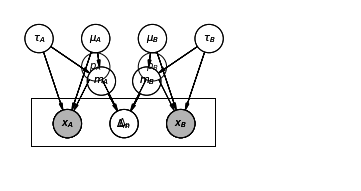

In [2]:
import daft
%matplotlib inline

pgm = daft.PGM([6, 3], origin=[0, 0])
pgm.add_node(daft.Node("muA", r"$\mu_A$", 1.5, 2.5))
pgm.add_node(daft.Node("tA", r"$\tau_A$", 0.5, 2.5))

pgm.add_node(daft.Node("muB", r"$\mu_B$", 2.5, 2.5))
pgm.add_node(daft.Node("tB", r"$\tau_B$", 3.5, 2.5))

pgm.add_node(daft.Node("mA", r"$m_A$", 1.6, 1.75))
pgm.add_node(daft.Node("mB", r"$m_B$", 2.4, 1.75))

pgm.add_node(daft.Node("A", r"$x_A$", 1, 1, aspect=1, observed=True))
pgm.add_node(daft.Node("B", r"$x_B$", 3, 1, aspect=1, observed=True))
pgm.add_node(daft.Node("d_m", r"$\Delta_{m}$", 2, 1, aspect=1))

pgm.add_node(daft.Node("pA", r"$p_A$", 1.5, 2))
pgm.add_node(daft.Node("pB", r"$p_B$", 2.5, 2))
pgm.add_node(daft.Node("A_conv", r"$x_A$", 1, 1, aspect=1, observed=True))
pgm.add_node(daft.Node("B_conv", r"$x_B$", 3, 1, aspect=1, observed=True))
pgm.add_node(daft.Node("d_conv", r"$\Delta_{p}$", 2, 1, aspect=1))

pgm.add_edge('muA','A')
pgm.add_edge('muB','B')
pgm.add_edge('tA','A')
pgm.add_edge('tB','B')

pgm.add_edge('muA','mA')
pgm.add_edge('tA','mA')
pgm.add_edge('muB','mB')
pgm.add_edge('tB','mB')

pgm.add_edge('mA','d_m')
pgm.add_edge('mB','d_m')

pgm.add_edge('pA','A_conv')
pgm.add_edge('pB','B_conv')
pgm.add_edge('pA','d_conv')
pgm.add_edge('pB','d_conv')

pgm.add_plate(daft.Plate([0.35, 0.7, 3.25, 0.75], shift=-0.1))
pgm.render()

pgm.figure.savefig("conversion_model.png", dpi=350)
pgm.figure.savefig("conversion_model.pdf", dpi=350, )